In [179]:
%matplotlib notebook
import pandas as pd
import numpy as np
import math
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib
from mlxtend.plotting import plot_confusion_matrix
import warnings
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
import scipy.fftpack as FFT
from sklearn.utils import shuffle
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = [12,5]

## help functions

In [180]:
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

def convert_to_datetime(x):
    dt = datetime.fromtimestamp(x // 1000000000)
    s = dt.strftime('%Y-%m-%d %H:%M:%S')
    s += '.' + str(int(x % 1000000000)).zfill(9)
    return s

def heatmap(cm, labels):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

    plt.show()
    
def preprocess(data, activity, drop_interval_begin = 3, drop_interval_end = 3):
    #convert nanoseconds to date 
    data['time'] = data['time'].apply(convert_to_datetime) 
    data['time'] = pd.to_datetime(data['time'])

#convert to same data type
    for i in range(1, 4): 
        data[column_names_org[i]] = data[column_names_org[i]].apply(convert_to_float)
    
#drop rows with NaN values 
    data.dropna(axis=0, how='any', inplace=True) #TODO: invullen met mean, mod of median / interpolatie

#drop duplicates 
    data.drop_duplicates(subset=None, keep='first', inplace = True)
    
    #drop first and last 3 sec
    indexFirst = data[ (data['time'].iloc[0]+ pd.to_timedelta(drop_interval_begin, unit='s')) > data['time'] ].index
    data.drop(indexFirst , inplace=True)
    indexLast = data[ (data['time'].iloc[-1]- pd.to_timedelta(drop_interval_end, unit='s')) < data['time'] ].index
    data.drop(indexLast , inplace=True)
    
    #add activity label
    data['activity'] = activity
    
    return data

#feature extraction
def get_mean_window(df):
    return df.mean()

def get_min_window(df):
    return df.min()

def get_max_window(df):
    return df.max()

def get_std_window(df):
    return df.std()

def get_med_window(df):
    return df.median()

#TODO: scipy integrate
#TODO: voor elke as apart??
#measure of activity level (m/s²)
def get_signal_magnitude_area(df):
        sum = 0
        for i in range(0, len(df)):
            sum += (abs(df['x'].iloc[i]) + abs(df['y'].iloc[i]) + abs(df['z'].iloc[i]))
        return sum /len(df)
    #result = integrate.quad(lambda t: df['x'].apply(lambda n : abs(n)) + df['y'].apply(lambda n : abs(n)) + df['z'].apply(lambda n : abs(n)), 0, len(df))

#TODO: voor elke as apart??
#degree of movement intensity (m/s²)
def get_signal_magnitude_vector(df):
    sum = 0
    for i in range(0, len(df)):
        sum += math.sqrt(df['x'].iloc[i] * df['x'].iloc[i] + df['y'].iloc[i] * df['y'].iloc[i] + df['z'].iloc[i] * df['z'].iloc[i])
    return sum

#average angle (radian) between accelerometer vector and x as (parallel with arm)
def get_tilt_angle(df):
    df_cos = pd.DataFrame(columns=["tilt_ang"])
    df_dot = df['x']
    for i in range(0, len(df)):
        s = pd.Series({"tilt_ang" : (df_dot.iloc[i])/(math.sqrt(df['x'].iloc[i]*df['x'].iloc[i] + df['y'].iloc[i]*df['y'].iloc[i] + df['z'].iloc[i]*df['z'].iloc[i]))})
        df_cos=df_cos.append(s, ignore_index=True)
    df_angle = np.arccos(df_cos)
    return df_angle.mean()['tilt_ang']

def get_power_spectral_density(df):
    df_psd = np.abs(df)**2
    return df_psd.sum()

#TODO: datatype is object en niet compex nr
def get_entropy(df):
    entropy = []
    pdf = df / df.sum()
    for i in range (1, len(pdf.columns)):
        entropy.append(np.complex(-np.nansum(pdf.iloc[:,i] * np.log2(pdf.iloc[:,i]))))
    return entropy

#generate windows with 50% overlap
def windows(df, time, overlap):
    start = df.iloc[0]
    while  (start + pd.to_timedelta(time, unit='s')) < df.iloc[-1]:
        yield start, (start + pd.to_timedelta(time, unit='s'))
        if overlap:
            start += pd.to_timedelta(time/2, unit='s')
        else:
            start += pd.to_timedelta(time, unit='s')
        
def feature_extraction_segmentation(data, window, overlap):
    column_names = ["x_mean", "y_mean", "z_mean", "x_min", "y_min", "z_min", "x_max", "y_max", "z_max",
                "x_std", "y_std", "z_std", "x_med", "y_med", "z_med", "activity"]
    df = pd.DataFrame(columns = column_names)

    for (start, end) in windows(data['time'], window, overlap):
        vw1 = data['time'] >= start
        vw2 = data['time'] < end
        mean = get_mean_window(data[vw1 & vw2])
        min = get_min_window(data[vw1 & vw2])
        max = get_max_window(data[vw1 & vw2])
        std = get_std_window(data[vw1 & vw2])
        med = get_med_window(data[vw1 & vw2])
        sma = get_signal_magnitude_area(data[vw1 & vw2])
        smv = get_signal_magnitude_vector(data[vw1 & vw2])
        tilt = get_tilt_angle(data[vw1 & vw2])
        #fourrier transform
        t_x = data[vw1 & vw2][['time','x']].set_index('time')
        t_y = data[vw1 & vw2][['time','y']].set_index('time')
        t_z = data[vw1 & vw2][['time', 'z']].set_index('time')

        df_f = pd.DataFrame(columns=['f', 'x_f', 'y_f', 'z_f'])

    #TODO: determine sampling rate (datapoints per second)
        sampling_rate = 18

        df_f['x_f'] = FFT.fft(t_x).ravel()
        df_f['y_f'] = FFT.fft(t_y).ravel()
        df_f['z_f'] = FFT.fft(t_z).ravel()
        df_f['f'] = FFT.fftfreq(len(df_f['x_f'])) * sampling_rate

        psd = get_power_spectral_density(df_f)
        #entropy = get_entropy(df_f)

        df = df.append(pd.Series({'x_mean': mean['x'], 'y_mean': mean['y'], 'z_mean': mean['z'], "x_min" : min['x'],
                              "y_min" : min['y'], "z_min" : min['z'], "x_max" : max['x'], "y_max" : max['y'], "z_max" : max['z'],
                              "x_std" : std['x'], "y_std" : std['y'], "z_std" : std['z'], "x_med" : med['x'], "y_med" : med['y'], "z_med" : med['z'],
                              "sma" : sma, "smv" : smv, "tilt" : tilt, "x_psd" : psd['x_f'], "y_psd" : psd['y_f'], "z_psd" : psd['z_f']
                              , "activity" : data['activity'].iloc[0]}), ignore_index=True) # "x_entropy" : entropy[0], "y_entropy" : entropy[1], "z_entropy" : entropy[2],
    return df


# preprocessing

## jump_mixed: slow and fast jumping

In [181]:
column_names_org = ['time', 'x', 'y', 'z']

jump_mixed = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\normal2.csv", sep=';', header=0, skipinitialspace=True)

jump_mixed.shape

(2730, 4)

In [182]:
jump_mixed = preprocess(jump_mixed, "normal")

jump_mixed.tail()

time         x          y          z activity
2514 1970-01-01 01:21:37.145528320  2.012364   9.985249 -16.204195   normal
2515 1970-01-01 01:21:37.164926976  1.706083  -5.216353 -16.089340   normal
2516 1970-01-01 01:21:37.184325632 -2.914458  -4.486542 -14.821143   normal
2517 1970-01-01 01:21:37.203462144 -5.053641  -9.008977  -9.745967   normal
2518 1970-01-01 01:21:37.224171520 -8.075776 -15.165709  -5.962914   normal

<IPython.core.display.Javascript object>


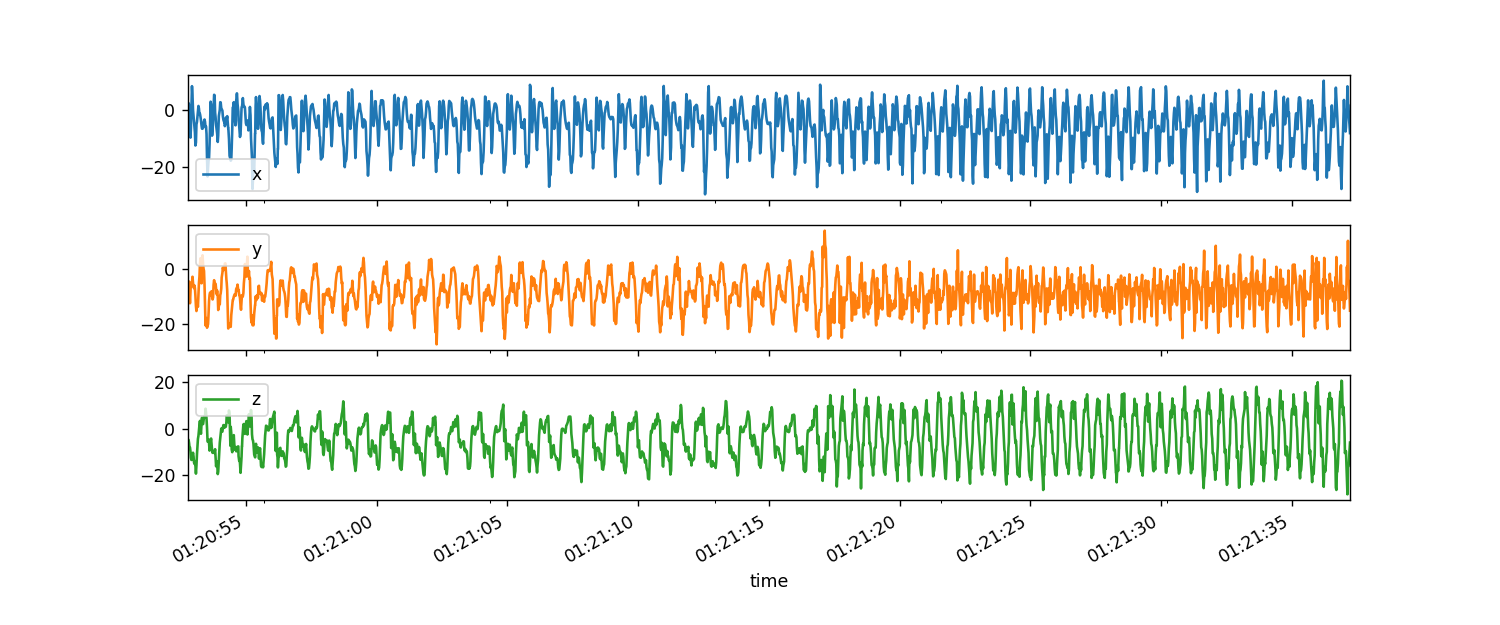

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B0541F488>,
      dtype=object)

In [183]:
jump_mixed.plot(x='time', subplots=True)

#### number of turns

<IPython.core.display.Javascript object>


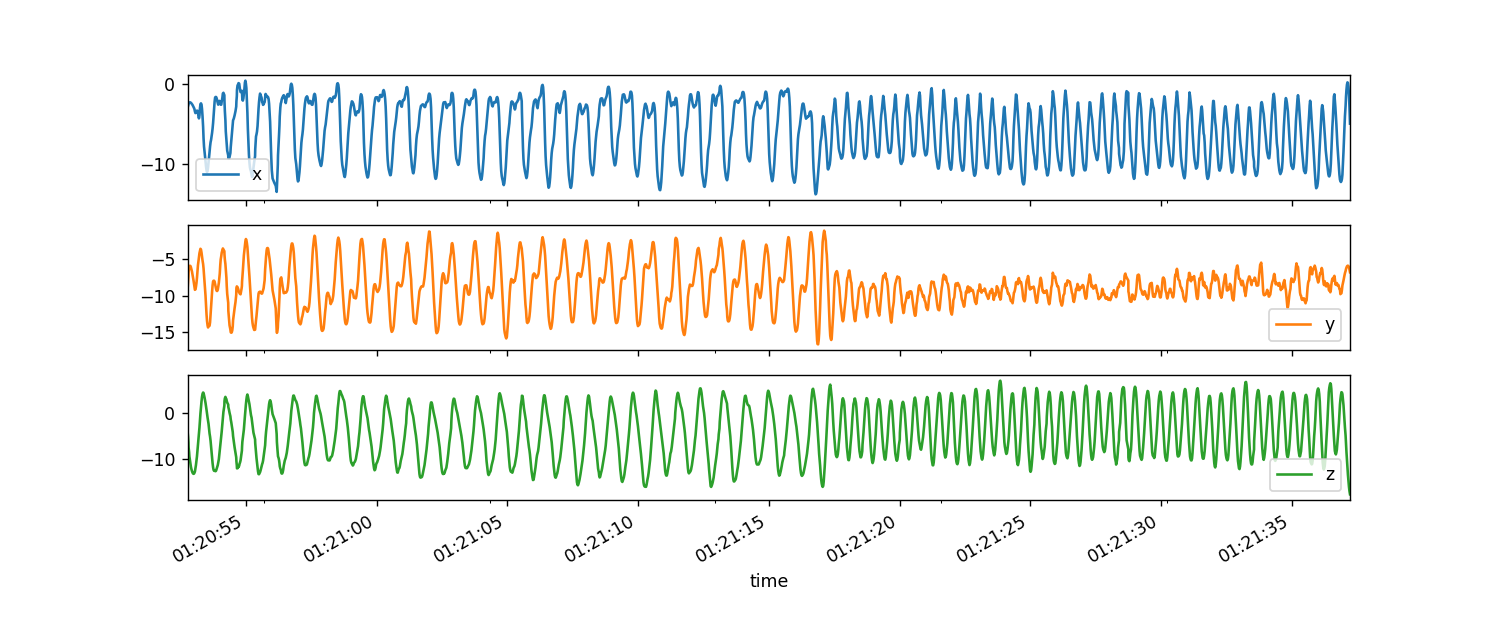

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B054DB1C8>,
      dtype=object)

In [184]:
#smoothing signal (eig niet nodig)
period = pd.DataFrame(jump_mixed)
period['x'] = savgol_filter(period[ 'x'].to_numpy(), 31, 3)
period['y'] = savgol_filter(period[ 'y'].to_numpy(), 31, 3)
period['z'] = savgol_filter(period[ 'z'].to_numpy(), 31, 3)
period.plot(x='time', subplots=True)

In [185]:
def get_number_of_turns(df, col):
    duration = df['time'].iloc[-1] - df['time'].iloc[0] 
    local_min = pd.DataFrame()
    local_min = df[(df[col].shift(1) > df[col]) & (df[col].shift(-1) > df[col])][['time', col]].reset_index()
    local_min['deltaT'] = local_min.time - local_min.time.shift(1)
    return duration/(local_min['deltaT'].mean())

turns_x = get_number_of_turns(jump_mixed[['time','x']], "x")
turns_y = get_number_of_turns(jump_mixed[['time','y']], "y")
turns_z = get_number_of_turns(jump_mixed[['time','z']], "z")

(turns_x + turns_y + turns_z)/3

133.01574784235063

## jump_fast

In [186]:
jump_fast = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast.csv", sep=';', header=0, skipinitialspace=True)
jump_fast2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast (meting2).csv", sep=';', header=0, skipinitialspace=True)
jump_fast_right = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast_tim(meting2).csv", sep=';', header=0, skipinitialspace=True)

jump_fast = preprocess(jump_fast, "jump_fast")
jump_fast2 = preprocess(jump_fast2, "jump_fast")
jump_fast_right = preprocess(jump_fast_right, "jump_fast")

jump_fast_right

time          x          y          z   activity
209  1970-01-01 11:43:22.339778560   7.946564 -11.196017  -6.731010  jump_fast
210  1970-01-01 11:43:22.356555776   9.427721 -18.549162 -12.638889  jump_fast
211  1970-01-01 11:43:22.377527296  20.575882  -8.961121  -9.073584  jump_fast
212  1970-01-01 11:43:22.394304512   2.139184 -17.730816   3.859623  jump_fast
213  1970-01-01 11:43:22.415276032   0.574277  -8.032705  -5.005785  jump_fast
...                            ...        ...        ...        ...        ...
1732 1970-01-01 11:43:51.725072384   7.073184 -12.959527   6.037092  jump_fast
1733 1970-01-01 11:43:51.741849600   9.257831 -25.363920   5.814559  jump_fast
1734 1970-01-01 11:43:51.762821120   3.407379 -25.751556   7.077970  jump_fast
1735 1970-01-01 11:43:51.783792640   4.603791 -23.693729  11.090733  jump_fast
1736 1970-01-01 11:43:51.800569856   6.166304 -22.717459   6.343373  jump_fast

[1525 rows x 5 columns]

<IPython.core.display.Javascript object>


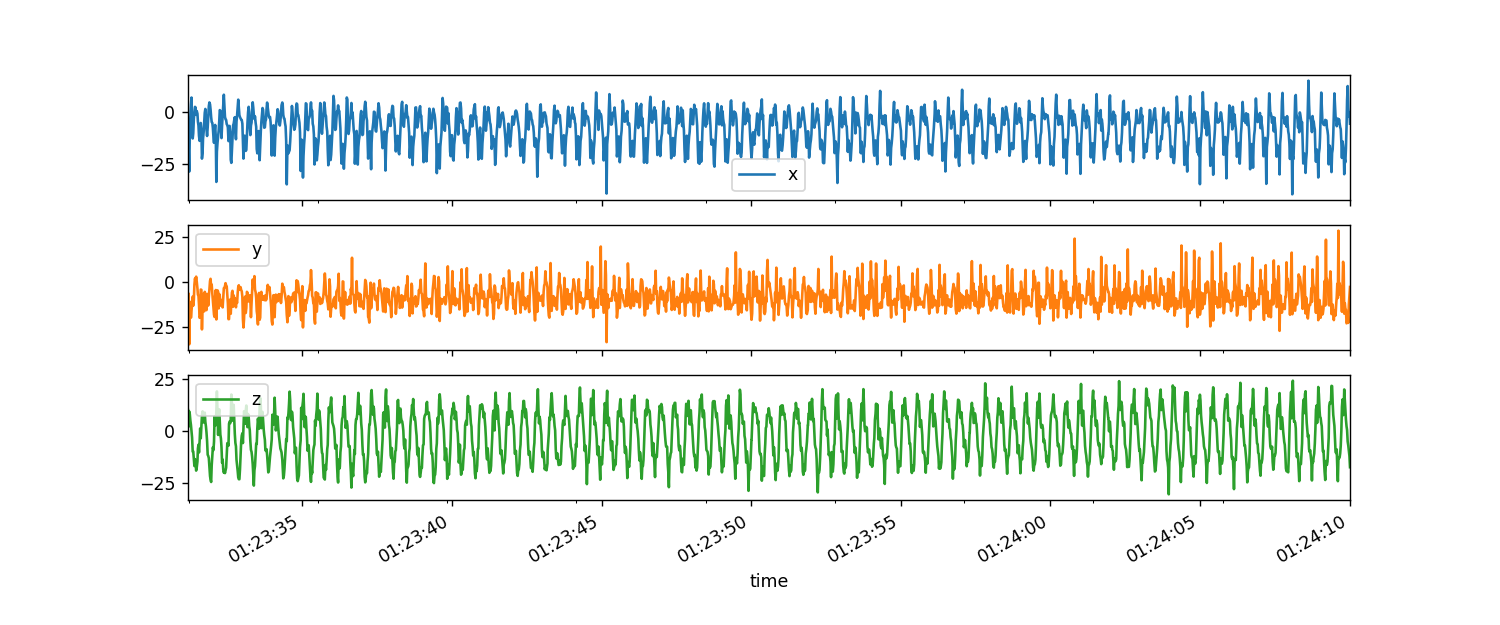

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B0560E6C8>,
      dtype=object)

In [187]:
jump_fast.plot(x='time', subplots=True)

<IPython.core.display.Javascript object>


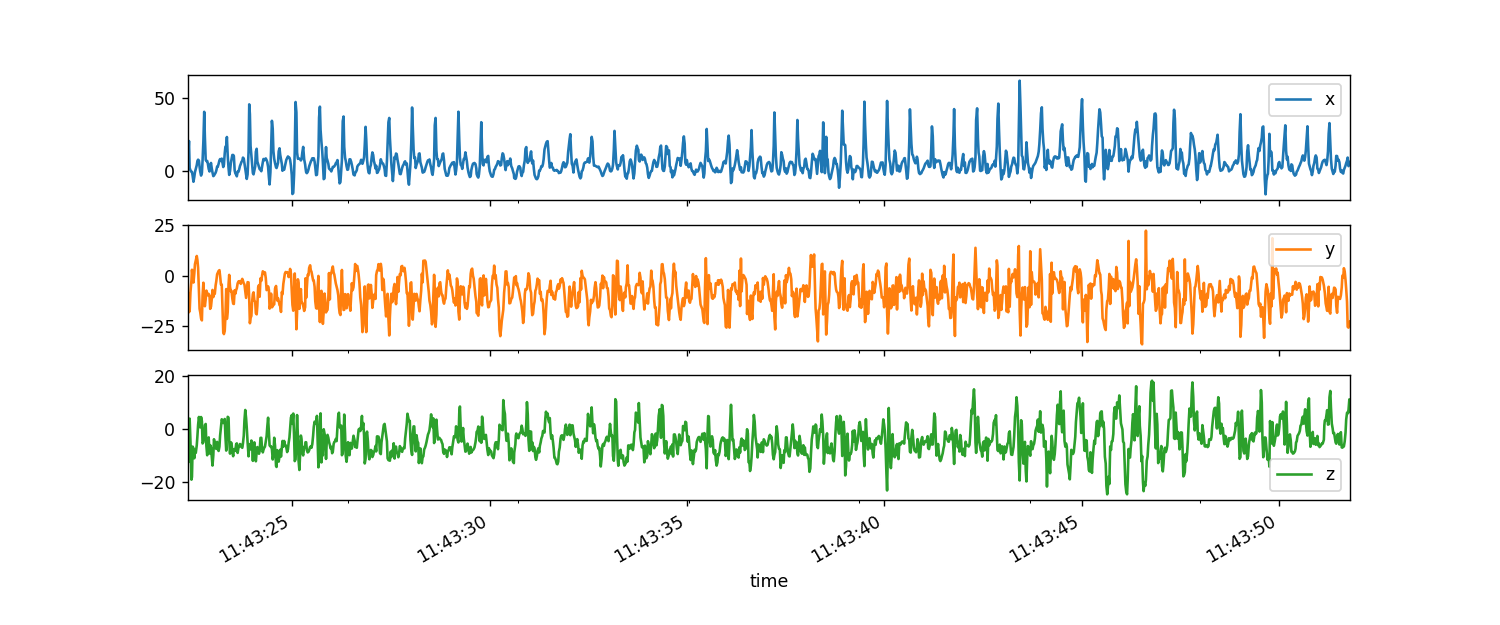

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B0572CCC8>,
      dtype=object)

In [188]:
jump_fast_right.plot(x='time', subplots=True)

In [189]:
#segmentation + feature extraction
jump_fast = feature_extraction_segmentation(jump_fast,10, True)
jump_fast2 = feature_extraction_segmentation(jump_fast2,10, True)
jump_fast_right = feature_extraction_segmentation(jump_fast_right,10, True)
jump_fast_right

x_mean    y_mean    z_mean      x_min      y_min      z_min      x_max  \
0  5.874449 -8.469493 -4.737341 -15.641882 -29.967710 -19.070797  47.212784   
1  5.297723 -8.922404 -4.706065  -9.250652 -29.967710 -15.828522  43.451267   
2  5.631480 -8.421006 -5.088449 -11.349157 -32.566315 -23.129025  47.954559   
3  8.687849 -7.901438 -4.587096 -11.349157 -34.018761 -24.576681  61.765930   

       y_max      z_max      x_std  ...     x_med     y_med     z_med  \
0   9.743574  10.808380   8.778388  ...  4.622933 -8.130812 -5.324031   
1   8.666803  11.150554   7.518612  ...  4.088138 -8.484949 -4.991428   
2  13.804193  14.859428   8.189203  ...  4.007978 -8.331809 -5.328816   
3  22.284357  18.104095  10.773890  ...  5.958128 -7.568499 -5.313263   

    activity        sma          smv      tilt         x_psd         y_psd  \
0  jump_fast  22.259551  7709.918308  1.188526  57715.808471  68016.673228   
1  jump_fast  21.715111  7505.503471  1.224588  43594.699376  68195.395727   
2  jump_fast  22.054901  7574.142186  1.224246  50901.667602  65156.566226   
3  jump_fast  25.821342  9033.537880  1.085030  99109.641177  70869.843617   

          z_psd  
0  23838.739049  
1  24042.868957  
2  26504.088465  
3  37123.734504  

[4 rows x 22 columns]

In [190]:
jump_fast = pd.concat([jump_fast, jump_fast2, jump_fast_right], ignore_index=True)
jump_fast

x_mean     y_mean    z_mean      x_min      y_min      z_min      x_max  \
0  -7.583159  -8.936538 -3.239117 -34.935211 -34.614571 -27.349962   8.568698   
1  -8.196665  -8.206268 -2.434212 -39.397823 -33.413376 -27.349962   9.669396   
2  -8.169064  -7.995196 -2.028957 -39.397823 -33.413376 -28.922047   9.669396   
3  -8.246004  -8.140373 -2.292107 -34.262829 -22.076181 -29.675787  10.435100   
4  -8.280305  -8.198424 -1.687567 -34.262829 -23.212772 -29.675787  10.983056   
5  -8.309037  -7.785291 -1.006954 -34.858639 -24.878178 -30.606594  10.983056   
6  -4.744691  -9.403931 -2.639542 -32.013573 -36.191441 -27.768707  16.943577   
7  -5.161254  -9.538290 -1.738880 -32.384460 -29.343184 -19.235901  13.773088   
8  -5.429781  -9.660199 -1.580376 -32.384460 -29.178080 -20.181067  10.535598   
9  -5.095638  -9.906830 -1.794013 -29.608788 -34.913673 -20.446669  11.722438   
10 -5.095262 -10.126370 -1.405372 -36.258442 -34.913673 -23.150558  11.722438   
11 -5.339242 -10.214119 -1.028641 -36.258442 -29.970104 -23.150558  14.093725   
12  5.874449  -8.469493 -4.737341 -15.641882 -29.967710 -19.070797  47.212784   
13  5.297723  -8.922404 -4.706065  -9.250652 -29.967710 -15.828522  43.451267   
14  5.631480  -8.421006 -5.088449 -11.349157 -32.566315 -23.129025  47.954559   
15  8.687849  -7.901438 -4.587096 -11.349157 -34.018761 -24.576681  61.765930   

        y_max      z_max      x_std  ...     x_med      y_med     z_med  \
0   13.466805  20.130817   8.144810  ... -6.446264  -9.116654 -2.969493   
1   19.688145  21.080767   8.056542  ... -6.782456  -9.156136 -1.135394   
2   19.688145  21.080767   8.146689  ... -6.300302  -8.797212 -1.366302   
3   16.457834  20.298315   8.213103  ... -6.300302  -8.883354 -1.877169   
4   24.086153  23.105095   8.262989  ... -6.092126  -9.090333 -0.830309   
5   24.086153  24.160330   8.374299  ... -5.781060  -8.922835 -0.179462   
6   10.650454  19.118652   9.427057  ... -1.660619  -8.700303 -3.503092   
7   10.650454  21.824936   9.223164  ... -2.239682  -8.964710 -3.060420   
8   13.962120  21.824936   9.539299  ... -2.384447  -9.460024 -2.727818   
9   13.962120  17.599211   9.725307  ... -1.607977  -9.765109 -2.663212   
10  13.576876  18.857836   9.907339  ... -1.490728  -9.939785 -2.294717   
11   6.431907  18.857836  10.005281  ... -1.737189 -10.167104 -2.099702   
12   9.743574  10.808380   8.778388  ...  4.622933  -8.130812 -5.324031   
13   8.666803  11.150554   7.518612  ...  4.088138  -8.484949 -4.991428   
14  13.804193  14.859428   8.189203  ...  4.007978  -8.331809 -5.328816   
15  22.284357  18.104095  10.773890  ...  5.958128  -7.568499 -5.313263   

     activity        sma          smv      tilt         x_psd         y_psd  \
0   jump_fast  28.340647  9663.305053  1.985967  64207.783263  60427.133638   
1   jump_fast  28.576395  9686.469888  2.011383  68359.361844  55280.738295   
2   jump_fast  28.158280  9531.324195  2.008742  68880.549589  54461.103041   
3   jump_fast  28.494259  9684.671500  2.010670  70096.498010  56013.024228   
4   jump_fast  28.250489  9646.311690  2.011202  70951.912004  57924.308969   
5   jump_fast  28.473746  9674.101919  2.007731  72158.576880  57964.743141   
6   jump_fast  25.965510  8825.162806  1.805726  57718.129532  77212.911355   
7   jump_fast  25.569721  8622.012711  1.838948  57778.271900  70539.160451   
8   jump_fast  25.980857  8716.163456  1.837307  62318.025752  69200.027110   
9   jump_fast  26.144589  8800.194663  1.796696  62469.379750  75903.095133   
10  jump_fast  26.218315  8842.828749  1.798779  64194.484393  75185.898838   
11  jump_fast  26.346908  8868.743554  1.824236  66521.508996  73338.651340   
12  jump_fast  22.259551  7709.918308  1.188526  57715.808471  68016.673228   
13  jump_fast  21.715111  7505.503471  1.224588  43594.699376  68195.395727   
14  jump_fast  22.054901  7574.142186  1.224246  50901.667602  65156.566226   
15  jump_fast  25.821342  9033.537880  1.085030  99109.641177  70869.843617   

        

## jump_slow

In [191]:
jump_slow = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow.csv", sep=';', header=0, skipinitialspace=True)
jump_slow2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow1 (meting2).csv", sep=';', header=0, skipinitialspace=True)
jump_slow_rigth = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow_tim.csv", sep=';', header=0, skipinitialspace=True)

jump_slow = preprocess(jump_slow, "jump_slow")
jump_slow2 = preprocess(jump_slow2, "jump_slow")
jump_slow_rigth = preprocess(jump_slow_rigth, "jump_slow")

jump_slow_rigth

time         x          y         z   activity
244  1970-01-01 11:39:31.325902848  3.577270  -9.265009 -6.453443  jump_slow
245  1970-01-01 11:39:31.342680064  3.527021 -10.573883 -6.137590  jump_slow
246  1970-01-01 11:39:31.363651584  3.637090 -11.598011 -6.494121  jump_slow
247  1970-01-01 11:39:31.384623104  3.072384 -11.724831 -6.726224  jump_slow
248  1970-01-01 11:39:31.401400320  2.833102 -11.432906 -6.855437  jump_slow
...                            ...       ...        ...       ...        ...
2096 1970-01-01 11:40:07.069761536  8.511271  -5.166104  7.082755  jump_slow
2097 1970-01-01 11:40:07.090733056  9.643075  -4.874180  8.207381  jump_slow
2098 1970-01-01 11:40:07.107510272  9.415757  -3.905087  8.712267  jump_slow
2099 1970-01-01 11:40:07.128481792  9.008977  -3.177669  8.020741  jump_slow
2100 1970-01-01 11:40:07.149453312  8.647661  -3.457629  8.767303  jump_slow

[1856 rows x 5 columns]

<IPython.core.display.Javascript object>


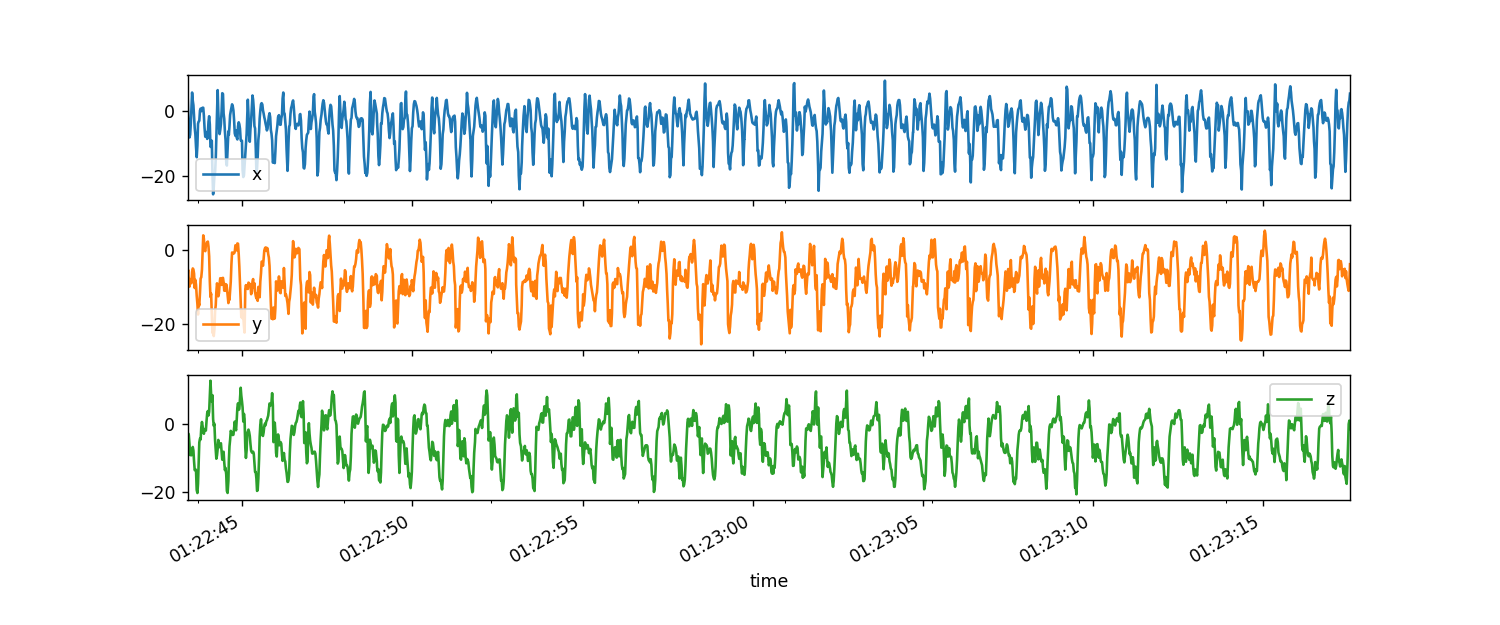

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B058ADBC8>,
      dtype=object)

In [192]:
jump_slow.plot(x='time', subplots=True)

<IPython.core.display.Javascript object>


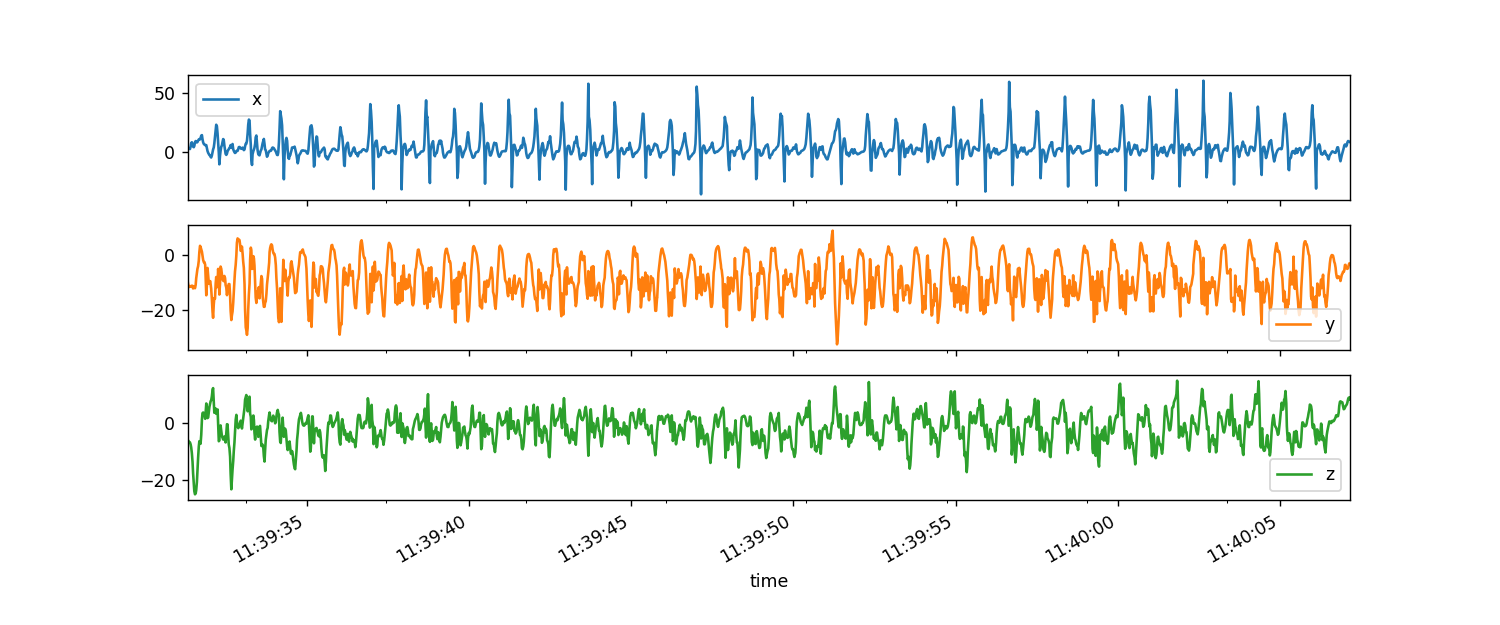

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B059C9848>,
      dtype=object)

In [193]:
jump_slow_rigth.plot(x='time', subplots=True)

In [194]:
turns_x = get_number_of_turns(jump_slow[['time','x']], "x")
turns_y = get_number_of_turns(jump_slow[['time','y']], "y")
turns_z = get_number_of_turns(jump_slow[['time','z']], "z")

(turns_x + turns_y + turns_z)/3

318.39896959544143

<IPython.core.display.Javascript object>


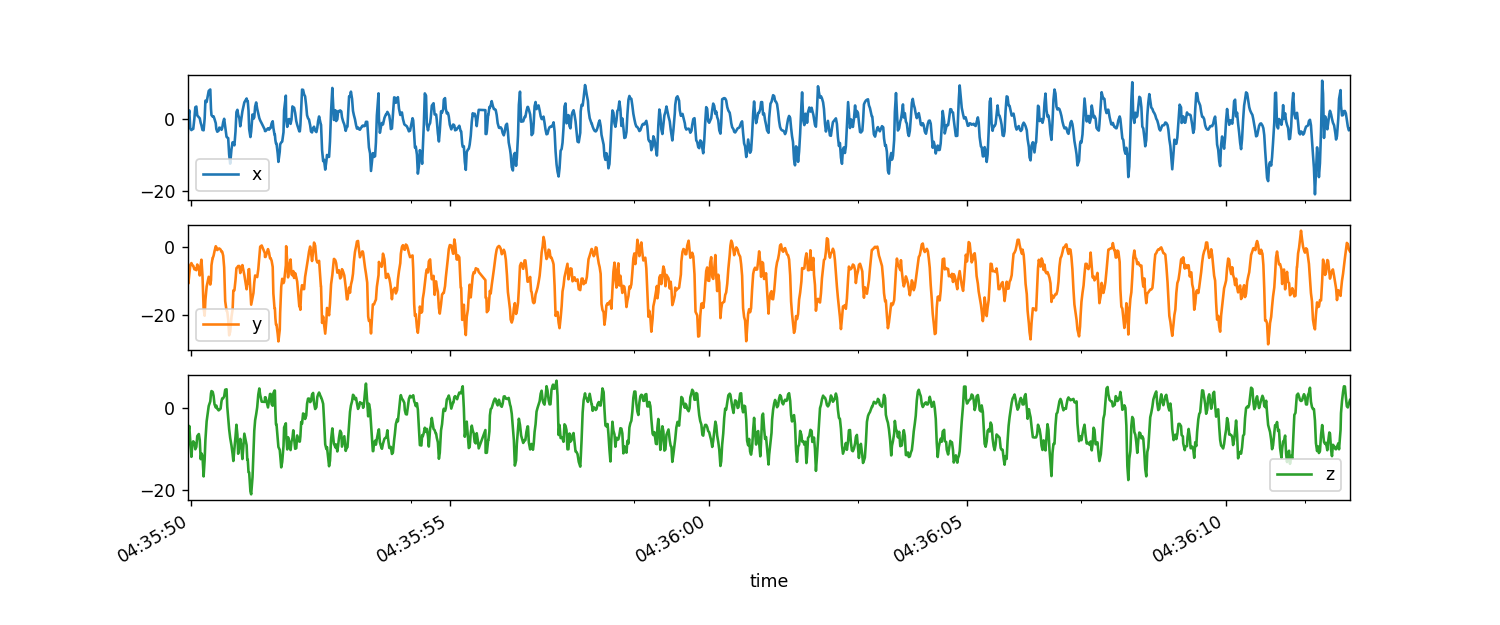

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B058AC948>,
      dtype=object)

In [195]:
jump_slow2.plot(x='time', subplots=True)

### differences between hands

In [196]:
jump_slow_right = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow_right2.csv", sep=';', header=0, skipinitialspace=True)

jump_slow_right = preprocess(jump_slow_right, "jump_slow")

jump_slow_right

time          x          y         z   activity
156  1970-01-01 06:03:48.898168832  -4.953143 -14.878572  1.787439  jump_slow
157  1970-01-01 06:03:48.914946048  -4.240082 -13.222738  3.012564  jump_slow
158  1970-01-01 06:03:48.933820416  -8.599805  -9.298509  2.076970  jump_slow
159  1970-01-01 06:03:48.956889088  -8.432307  -6.472585  1.373480  jump_slow
160  1970-01-01 06:03:48.973666304  -3.282953  -5.137390  1.887937  jump_slow
...                            ...        ...        ...       ...        ...
2574 1970-01-01 06:04:35.526246400  12.643675 -17.874386  2.098505  jump_slow
2575 1970-01-01 06:04:35.557703680  15.239887 -17.785851  2.883351  jump_slow
2576 1970-01-01 06:04:35.568189440  15.187245 -21.001804  1.741975  jump_slow
2577 1970-01-01 06:04:35.584966656  14.062618 -20.618952  0.533599  jump_slow
2578 1970-01-01 06:04:35.603841024  12.600604 -21.568903 -1.785046  jump_slow

[2423 rows x 5 columns]

<IPython.core.display.Javascript object>


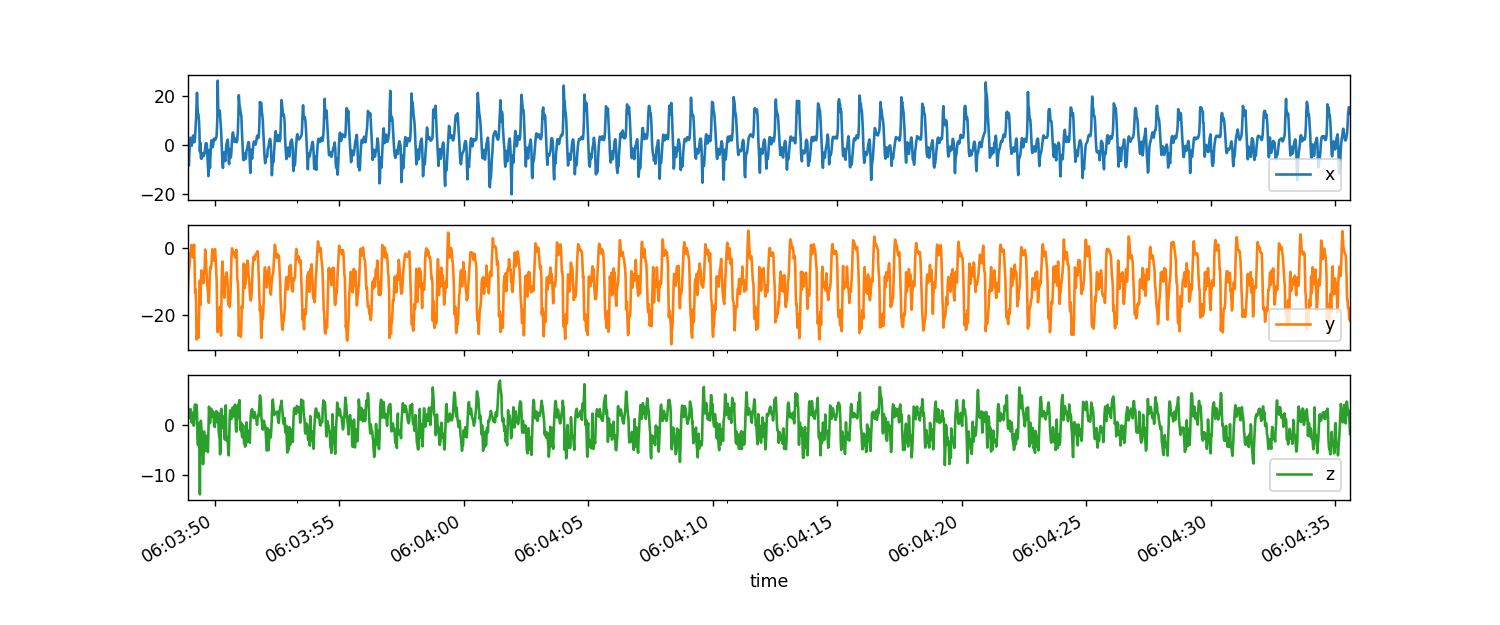

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B05C0E988>,
      dtype=object)

In [197]:
jump_slow_right.plot(x='time', subplots=True)

In [198]:
jump_slow = jump_slow.reset_index(drop=True)
jump_slow2 = jump_slow2.reset_index(drop=True)
diff_left = jump_slow.loc[:,'x':'z'] - jump_slow2.loc[:,'x':'z']
diff_left['time'] =  jump_slow['time']
diff_left

x         y         z                          time
0     11.758330  2.084148  6.635297 1970-01-01 01:22:43.384205312
1     -1.603191  5.201997  3.110669 1970-01-01 01:22:43.403997184
2     -7.085148 -0.375672  1.024128 1970-01-01 01:22:43.422347264
3     -5.491528 -4.807180  2.000399 1970-01-01 01:22:43.442663424
4     -4.113262 -3.314060  2.636890 1970-01-01 01:22:43.461931008
...         ...       ...       ...                           ...
1768        NaN       NaN       NaN 1970-01-01 01:23:17.489008640
1769        NaN       NaN       NaN 1970-01-01 01:23:17.509193728
1770        NaN       NaN       NaN 1970-01-01 01:23:17.528461312
1771        NaN       NaN       NaN 1970-01-01 01:23:17.548122112
1772        NaN       NaN       NaN 1970-01-01 01:23:17.566734336

[1773 rows x 4 columns]

### different turn direction

In [199]:
jump_slow_turn_diff = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow_turn_diff.csv", sep=';', header=0, skipinitialspace=True)

jump_slow_turn_diff = preprocess(jump_slow_turn_diff, "jump_slow")

jump_slow_turn_diff

time         x         y         z   activity
210  1970-01-01 11:26:39.901122560 -1.454836  1.488336 -1.995614  jump_slow
211  1970-01-01 11:26:39.922094080 -2.545963  1.538585 -1.689333  jump_slow
212  1970-01-01 11:26:39.938871296 -1.392623  2.402394 -1.179662  jump_slow
213  1970-01-01 11:26:39.959842816 -1.397408  3.134598 -1.751546  jump_slow
214  1970-01-01 11:26:39.976620032 -2.775674  2.340181 -1.962115  jump_slow
...                            ...       ...       ...       ...        ...
3056 1970-01-01 11:27:34.825533440  1.172483 -8.193025 -0.296710  jump_slow
3057 1970-01-01 11:27:34.846504960  1.045663 -7.298109 -0.512064  jump_slow
3058 1970-01-01 11:27:34.867476480  1.057628 -7.628319 -1.689333  jump_slow
3059 1970-01-01 11:27:34.884253696  1.186840 -8.556734 -3.323631  jump_slow
3060 1970-01-01 11:27:34.905225216  1.416551 -8.401200 -3.969693  jump_slow

[2850 rows x 5 columns]

<IPython.core.display.Javascript object>


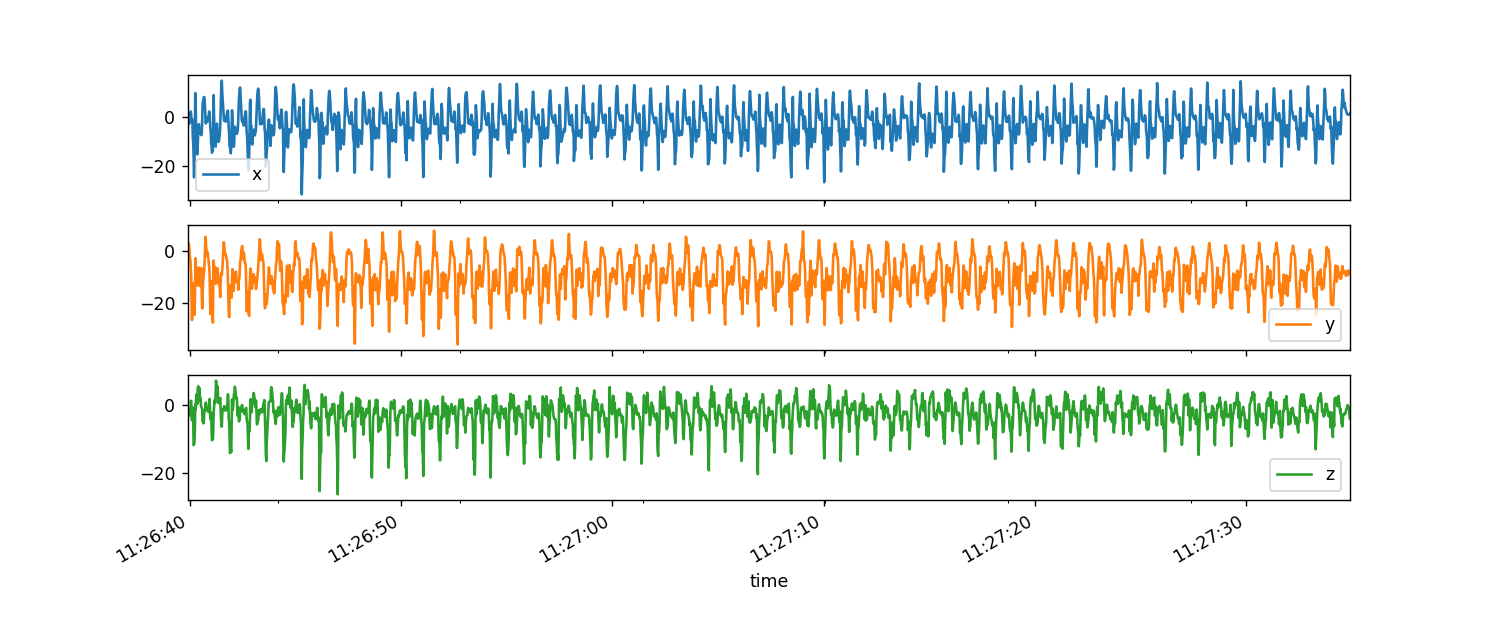

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B05D46148>,
      dtype=object)

In [200]:
jump_slow_turn_diff.plot(x='time', subplots=True)

### segmentation

In [201]:
#segmentation + feature extraction
jump_slow =  feature_extraction_segmentation(jump_slow,10, True)
jump_slow2 =  feature_extraction_segmentation(jump_slow2,10, True)
jump_slow_rigth = feature_extraction_segmentation(jump_slow_rigth,10, True)

jump_slow_rigth

x_mean    y_mean    z_mean      x_min      y_min      z_min      x_max  \
0  4.420618 -9.092482 -2.320927 -31.324442 -29.032118 -24.961926  44.618965   
1  4.541125 -9.417887 -1.192831 -31.616365 -24.538397 -12.052648  58.150375   
2  4.476976 -9.210593 -1.860263 -35.535809 -27.641888 -15.627524  58.150375   
3  4.633032 -9.374690 -2.101125 -35.535809 -32.465816 -17.233109  55.709698   
4  4.934287 -9.476360 -1.804258 -33.209984 -32.465816 -17.233109  59.758354   
5  5.084046 -8.971755 -1.639208 -32.252857 -25.136602 -15.309279  60.744194   

      y_max      z_max      x_std  ...     x_med      y_med     z_med  \
0  5.850451  12.043077   9.788514  ...  2.364109  -9.272188 -1.682154   
1  5.178068   9.932607  11.148619  ...  1.990829  -9.859625 -0.869791   
2  8.640483  12.602997  10.762388  ...  2.176272  -9.631111 -1.429712   
3  8.640483  14.155939  10.466429  ...  2.344966  -9.686146 -1.940579   
4  6.216553  14.155939  11.263867  ...  2.287539 -10.293923 -1.330409   
5  5.285745  14.634503  12.120951  ...  2.471786 -10.051051 -1.503889   

    activity        sma          smv      tilt         x_psd         y_psd  \
0  jump_slow  20.717948  7285.917702  1.314660  59774.399281  70674.352825   
1  jump_slow  20.268067  7192.969734  1.401211  74940.908545  68065.573103   
2  jump_slow  20.518029  7138.726811  1.395686  70266.026131  66589.929716   
3  jump_slow  21.403493  7393.048022  1.331873  67623.207126  73638.676136   
4  jump_slow  21.951672  7649.237479  1.285568  78054.842465  74954.413286   
5  jump_slow  22.065904  7726.039792  1.279891  89345.337159  69104.542442   

          z_psd  
0  18328.526219  
1   8162.838768  
2  11855.767349  
3  15230.492491  
4  16693.813598  
5  17432.872965  

[6 rows x 22 columns]

In [202]:
jump_slow = pd.concat([jump_slow, jump_slow2, jump_slow_rigth], ignore_index=True)
jump_slow

x_mean    y_mean    z_mean      x_min      y_min      z_min      x_max  \
0  -5.481726 -8.859617 -4.460138 -25.507490 -23.327627 -20.379671   6.252446   
1  -5.246818 -8.616536 -4.756654 -23.976084 -23.990440 -20.152351   5.816952   
2  -4.962876 -8.616176 -5.142804 -24.428326 -25.562525 -20.066210   8.379665   
3  -5.084023 -8.429078 -5.237145 -24.428326 -25.562525 -19.283758   9.126225   
4  -4.821293 -7.710523 -5.441408 -24.770500 -23.468805 -20.764915   9.126225   
5  -1.824405 -9.533217 -3.602798 -16.036697 -27.680172 -21.025732   9.276974   
6  -1.775280 -9.387140 -3.656141 -16.036697 -27.620352 -15.314065   9.276974   
7  -1.444872 -9.102247 -3.896550 -16.204195 -27.620352 -17.553747  10.059426   
8   4.420618 -9.092482 -2.320927 -31.324442 -29.032118 -24.961926  44.618965   
9   4.541125 -9.417887 -1.192831 -31.616365 -24.538397 -12.052648  58.150375   
10  4.476976 -9.210593 -1.860263 -35.535809 -27.641888 -15.627524  58.150375   
11  4.633032 -9.374690 -2.101125 -35.535809 -32.465816 -17.233109  55.709698   
12  4.934287 -9.476360 -1.804258 -33.209984 -32.465816 -17.233109  59.758354   
13  5.084046 -8.971755 -1.639208 -32.252857 -25.136602 -15.309279  60.744194   

       y_max      z_max      x_std  ...     x_med      y_med     z_med  \
0   3.897908  12.571890   6.594594  ... -4.156333  -9.358330 -3.842873   
1   3.471986   9.698111   6.474394  ... -3.507878  -8.634500 -4.521238   
2   4.733003   9.657433   6.412345  ... -3.379862  -8.459824 -5.484349   
3   4.733003   9.657433   6.499475  ... -3.670590  -7.877172 -5.827720   
4   3.445665   7.984849   6.393653  ... -3.436093  -6.996614 -5.661418   
5   3.086741   6.668797   4.710011  ... -1.703690  -8.793623 -3.993621   
6   3.086741   6.668797   4.655250  ... -1.610370  -8.749356 -3.979264   
7   2.708675   5.233103   4.566257  ... -1.208376  -8.182257 -4.071388   
8   5.850451  12.043077   9.788514  ...  2.364109  -9.272188 -1.682154   
9   5.178068   9.932607  11.148619  ...  1.990829  -9.859625 -0.869791   
10  8.640483  12.602997  10.762388  ...  2.176272  -9.631111 -1.429712   
11  8.640483  14.155939  10.466429  ...  2.344966  -9.686146 -1.940579   
12  6.216553  14.155939  11.263867  ...  2.287539 -10.293923 -1.330409   
13  5.285745  14.634503  12.120951  ...  2.471786 -10.051051 -1.503889   

     activity        sma          smv      tilt         x_psd         y_psd  \
0   jump_slow  22.073203  7278.048807  1.948170  38122.729864  60289.158910   
1   jump_slow  21.577906  7110.217192  1.934285  35931.563222  58457.163989   
2   jump_slow  21.371412  7097.985079  1.907326  34016.504689  57634.635965   
3   jump_slow  21.424590  7141.333982  1.914784  35228.614305  55974.492685   
4   jump_slow  20.570133  6903.279449  1.918249  33239.305649  50018.198748   
5   jump_slow  18.735621  6455.455090  1.757480  13218.883864  71247.711933   
6   jump_slow  18.536185  6373.607493  1.755715  12836.626288  69371.199271   
7   jump_slow  18.086007  6251.563921  1.736782  11861.219217  67521.456391   
8   jump_slow  20.717948  7285.917702  1.314660  59774.399281  70674.352825   
9   jump_slow  20.268067  7192.969734  1.401211  74940.908545  68065.573103   
10  jump_slow  20.518029  7138.726811  1.395686  70266.026131  66589.929716   
11  jump_slow  21.403493  7393.048022  1.331873  67623.207126  73638.676136   
12  jump_slow  21.951672  7649.237479  1.285568  78054.842465  74954.413286   
13  jump_slow  22.065904  7726.039792  1.279891  89345.337159  69104.542442   

           z_psd  
0   35914.763428  
1   36102.697376  
2   35710.669209  
3   35909.547769  
4   37528.722410  
5   21842.564175  
6   21074.262850  
7   22009.136444  
8   18328.526219  
9    8162.838768  
10  11855.767349  
11  15230.492491  
12  16693.813598  
13  17432.872965  

[14 rows x 22 columns]

## side swing

In [203]:
side_swing = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\side_swing.csv", sep=';', header=0, skipinitialspace=True)
side_swing2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\side_swing2 (meting2).csv", sep=';', header=0, skipinitialspace=True)
side_swing3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\side_swing3 (meting2).csv", sep=';', header=0, skipinitialspace=True)
side_swing_rigth = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\side_swing_tim.csv", sep=';', header=0, skipinitialspace=True)

side_swing = preprocess(side_swing, "side_swing")
side_swing2 = preprocess(side_swing2, "side_swing")
side_swing3 = preprocess(side_swing3, "side_swing")
side_swing_rigth = preprocess(side_swing_rigth, "side_swing")

side_swing_rigth

time         x         y         z    activity
277  1970-01-01 11:40:23.184277504  1.533799 -1.296910  7.281359  side_swing
278  1970-01-01 11:40:23.201054720  1.016950 -1.787439  6.690332  side_swing
279  1970-01-01 11:40:23.222026240  0.892523 -2.048256  6.501299  side_swing
280  1970-01-01 11:40:23.242997760  2.074577 -2.754139  6.407979  side_swing
281  1970-01-01 11:40:23.259774976  3.550949 -3.991228  6.597012  side_swing
...                            ...       ...       ...       ...         ...
2921 1970-01-01 11:41:14.220568576  0.318245 -3.242275  1.488336  side_swing
2922 1970-01-01 11:41:14.237345792  0.784846 -4.785645  1.488336  side_swing
2923 1970-01-01 11:41:14.258317312  1.107877 -5.321638  1.682154  side_swing
2924 1970-01-01 11:41:14.275094528  1.244268 -5.934200  2.050649  side_swing
2925 1970-01-01 11:41:14.296066048  1.799403 -7.046863  2.258825  side_swing

[2649 rows x 5 columns]

<IPython.core.display.Javascript object>


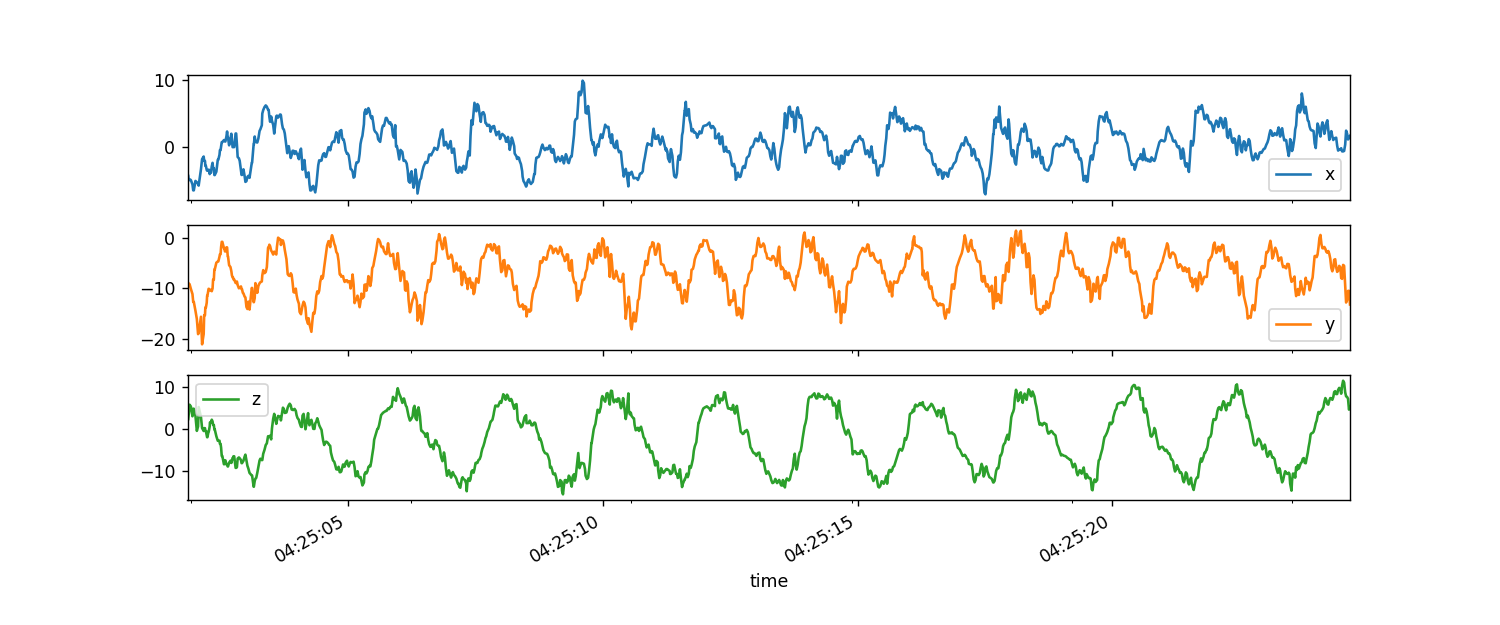

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B06E7E308>,
      dtype=object)

In [204]:
side_swing.plot(x='time', subplots=True)

<IPython.core.display.Javascript object>


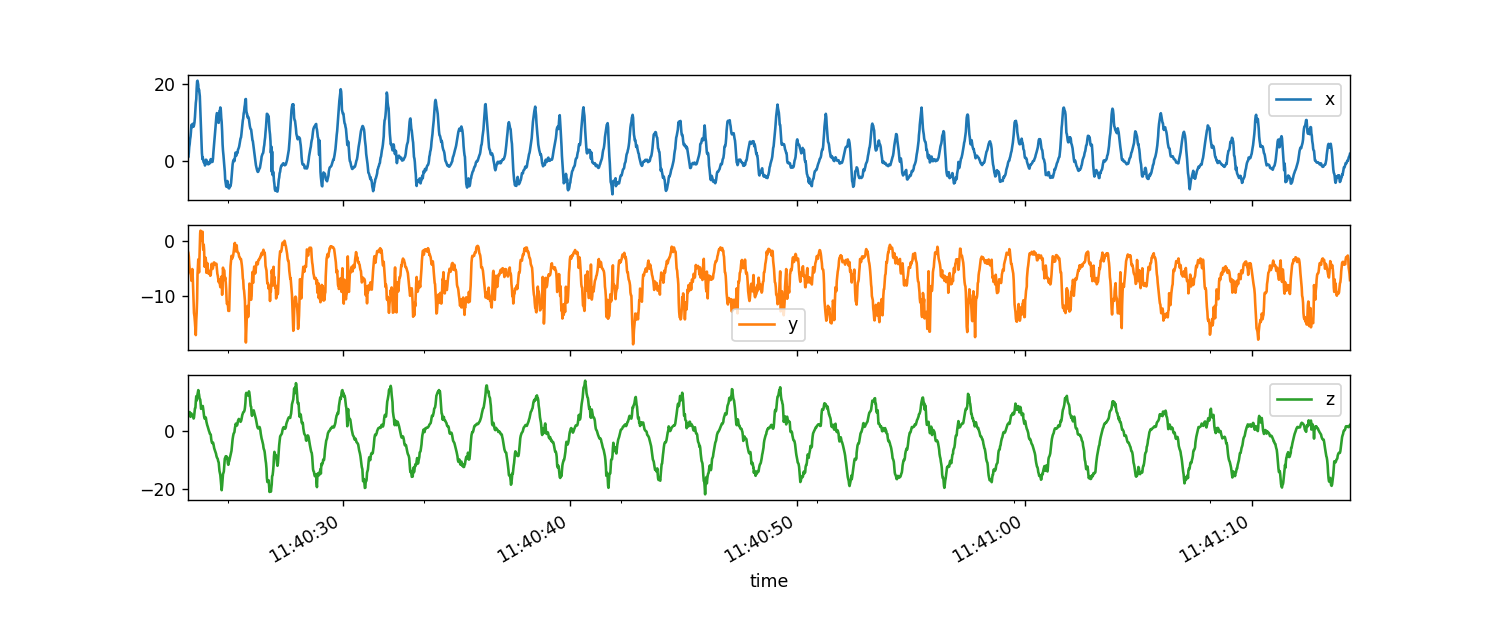

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B06F759C8>,
      dtype=object)

In [205]:
side_swing_rigth.plot(x='time', subplots=True)

In [206]:
#segmentation + feature extraction
side_swing =  feature_extraction_segmentation(side_swing,10, True)
side_swing2 =  feature_extraction_segmentation(side_swing2,10, True)
side_swing3 =  feature_extraction_segmentation(side_swing3,10, True)
side_swing_rigth =  feature_extraction_segmentation(side_swing_rigth,10, True)

side_swing_rigth

x_mean    y_mean    z_mean     x_min      y_min      z_min      x_max  \
0  3.430833 -6.141560 -1.081459 -8.078169 -18.415163 -21.135803  20.946770   
1  2.067306 -6.339289 -1.630298 -7.975278 -13.715659 -19.736002  18.711874   
2  1.541361 -7.126066 -0.300706 -8.800801 -18.742979 -19.688145  15.912271   
3  1.674619 -7.236423 -0.801309 -8.800801 -18.742979 -21.956541  14.151154   
4  1.099830 -6.488693 -2.060146 -7.905886 -14.926428 -21.956541  14.691931   
5  1.079666 -6.649188 -1.747978 -6.845866 -17.434105 -19.697716  14.691931   
6  1.423734 -6.559184 -2.481782 -5.965307 -17.434105 -19.697716  13.907085   
7  1.663866 -6.564681 -2.762301 -7.475178 -16.989040 -18.132811  13.907085   
8  1.579152 -7.433271 -2.380267 -7.475178 -17.898314 -19.597218  13.615161   

      y_max      z_max     x_std  ...     x_med     y_med     z_med  \
0  1.971686  16.828722  6.252229  ...  2.163112 -5.785845  0.165105   
1 -0.792024  16.019947  5.625433  ...  0.936790 -6.233303 -0.618545   
2 -0.792024  17.690138  5.341482  ...  0.532403 -6.916453  0.484546   
3 -0.940379  17.690138  4.827559  ...  0.811167 -6.800402  0.311067   
4 -0.940379  15.395421  4.386922  ...  0.251246 -6.112466 -0.220139   
5 -0.602991  15.395421  4.338321  ...  0.373280 -6.032306  0.033500   
6 -0.602991  13.098311  4.274622  ...  0.673579 -5.783452 -0.665205   
7 -1.390230  12.390036  4.536237  ...  0.738186 -5.877969 -1.110270   
8 -2.029114  10.463814  4.487396  ...  0.543171 -6.600601 -0.312263   

     activity        sma          smv      tilt         x_psd         y_psd  \
0  side_swing  18.986518  6103.001641  1.397671  26357.759248  26666.975838   
1  side_swing  17.530576  5653.411370  1.517087  18574.526058  26283.931526   
2  side_swing  17.620866  5715.594498  1.551019  15981.413277  32866.443367   
3  side_swing  17.621246  5780.622519  1.533127  13475.396428  33316.731063   
4  side_swing  16.592520  5550.601510  1.583755  10576.293958  27492.147653   
5  side_swing  16.510163  5626.098232  1.573652  10354.279172  30366.608009   
6  side_swing  17.027520  5807.841761  1.538788  10496.824789  29696.066986   
7  side_swing  17.056608  5730.898101  1.516083  12072.596164  28842.205073   
8  side_swing  16.295215  5559.774225  1.518449  11702.432872  35817.532741   

          z_psd  
0  42118.703738  
1  36218.464010  
2  31593.309976  
3  34209.421371  
4  36598.928030  
5  35058.557440  
6  38859.187958  
7  36268.633341  
8  25703.991560  

[9 rows x 22 columns]

In [207]:
side_swing  = pd.concat([side_swing, side_swing2, side_swing3, side_swing_rigth], ignore_index=True)
side_swing

x_mean    y_mean    z_mean     x_min      y_min      z_min      x_max  \
0  -0.297017 -7.481204 -2.936394 -7.003792 -21.140589 -15.529419   9.937392   
1   0.280569 -6.708557 -2.569527 -5.958128 -18.163918 -15.529419   9.937392   
2   0.236631 -6.702495 -2.280679 -7.121040 -16.917255 -14.562718   6.273981   
3  -0.151709 -6.735745 -2.689505 -7.707282 -20.054247 -19.812571   5.441278   
4   0.408326 -6.751972 -2.342814 -5.000999 -20.054247 -19.812571   7.118648   
5   0.888883 -6.827416 -1.947970 -4.484149 -19.032511 -17.283358   7.910672   
6   1.044490 -6.387672 -1.738607 -3.981657 -16.835899 -19.101904   7.910672   
7   1.260824 -6.066055 -1.517077 -3.981657 -16.835899 -19.101904   7.649854   
8   1.841067 -5.996649 -1.293461 -4.031906 -15.060426 -13.947763   8.822337   
9   3.430833 -6.141560 -1.081459 -8.078169 -18.415163 -21.135803  20.946770   
10  2.067306 -6.339289 -1.630298 -7.975278 -13.715659 -19.736002  18.711874   
11  1.541361 -7.126066 -0.300706 -8.800801 -18.742979 -19.688145  15.912271   
12  1.674619 -7.236423 -0.801309 -8.800801 -18.742979 -21.956541  14.151154   
13  1.099830 -6.488693 -2.060146 -7.905886 -14.926428 -21.956541  14.691931   
14  1.079666 -6.649188 -1.747978 -6.845866 -17.434105 -19.697716  14.691931   
15  1.423734 -6.559184 -2.481782 -5.965307 -17.434105 -19.697716  13.907085   
16  1.663866 -6.564681 -2.762301 -7.475178 -16.989040 -18.132811  13.907085   
17  1.579152 -7.433271 -2.380267 -7.475178 -17.898314 -19.597218  13.615161   

       y_max      z_max     x_std  ...     x_med     y_med     z_med  \
0   0.744168   9.710074  3.233253  ... -0.409172 -7.435696 -2.818745   
1   1.062413   9.126225  2.968060  ...  0.210568 -6.448657 -2.416751   
2   1.423729  10.478170  2.637663  ...  0.253640 -6.539584 -2.426322   
3   3.445665  11.026127  2.470456  ... -0.138784 -5.741578 -1.472782   
4   3.445665  10.956735  2.465428  ...  0.196211 -5.915058 -0.727418   
5   0.674776  13.655839  2.638613  ...  0.474975 -6.067001 -0.764506   
6   2.297110  14.155939  2.676115  ...  0.793221 -5.694918 -0.689133   
7   2.297110  14.155939  2.417659  ...  1.186840 -5.778667 -0.778863   
8  -0.502493  13.792230  2.264052  ...  1.777867 -5.134997 -1.095913   
9   1.971686  16.828722  6.252229  ...  2.163112 -5.785845  0.165105   
10 -0.792024  16.019947  5.625433  ...  0.936790 -6.233303 -0.618545   
11 -0.792024  17.690138  5.341482  ...  0.532403 -6.916453  0.484546   
12 -0.940379  17.690138  4.827559  ...  0.811167 -6.800402  0.311067   
13 -0.940379  15.395421  4.386922  ...  0.251246 -6.112466 -0.220139   
14 -0.602991  15.395421  4.338321  ...  0.373280 -6.032306  0.033500   
15 -0.602991  13.098311  4.274622  ...  0.673579 -5.783452 -0.665205   
16 -1.390230  12.390036  4.536237  ...  0.738186 -5.877969 -1.110270   
17 -2.029114  10.463814  4.487396  ...  0.543171 -6.600601 -0.312263   

      activity        sma          smv      tilt         x_psd         y_psd  \
0   side_swing  16.149872  5931.453638  1.538744   5661.218557  40965.941825   
1   side_swing  15.883275  5614.337201  1.496308   4604.114809  32128.194691   
2   side_swing  15.539203  5518.384103  1.501259   3625.912632  32395.902320   
3   side_swing  15.407214  5574.114436  1.549403   3167.251403  34378.244416   
4   side_swing  15.369452  5536.824829  1.483986   3222.621232  33179.816714   
5   side_swing  15.672656  5557.878739  1.443965   4008.776453  32398.248217   
6   side_swing  15.670249  5536.158342  1.439645   4267.661262  29405.171217   
7   side_swing  15.355500  5408.641743  1.423693   3845.356011  24986.818539   
8   side_swing  15.064704  5306.474710  1.351988   4414.397056  24009.843811   
9   side_swing  18.986518  6103.001641  1.397671  26357.759248  26666.975838   
10  side_swing  17.530576  5653.411370  1.517087  18574.526058  26283.931526   
11  side_swing  17.620866  5715.594498  1.551019  15981.413277  32866.443367   
12  side_swing  17.621246  5780.622519  1.533127  13475.396428  33316.731063   
13  side_swing 

## cross over

In [208]:
#cross_over = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over_slecht.csv", sep=';', header=0, skipinitialspace=True)
cross_over2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over2.csv", sep=';', header=0, skipinitialspace=True)
cross_over3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over3.csv", sep=';', header=0, skipinitialspace=True)
cross_over4 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over4.csv", sep=';', header=0, skipinitialspace=True)
cross_over5 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over5.csv", sep=';', header=0, skipinitialspace=True)

#cross_over = preprocess(cross_over, "cross_over")
cross_over2 = preprocess(cross_over2, "cross_over")
cross_over3 = preprocess(cross_over3, "cross_over")
cross_over4 = preprocess(cross_over4, "cross_over")
cross_over5 = preprocess(cross_over5, "cross_over")

cross_over5

time         x          y         z    activity
201 1970-01-01 11:23:59.791955968 -0.600598 -15.239887  3.785445  cross_over
202 1970-01-01 11:23:59.808733184  4.417150 -13.562519  5.352744  cross_over
203 1970-01-01 11:23:59.829704704  6.427122 -15.495919 -0.440279  cross_over
204 1970-01-01 11:23:59.846481920  6.089734 -19.448862  3.113062  cross_over
205 1970-01-01 11:23:59.867453440  3.885944 -14.921642  7.965706  cross_over
..                            ...       ...        ...       ...         ...
783 1970-01-01 11:24:09.975726080 -1.780260  -0.734597  1.227518  cross_over
785 1970-01-01 11:24:09.979920384 -1.780260  -0.734597  1.227518  cross_over
786 1970-01-01 11:24:09.996697600 -0.725025  -4.012764  0.751346  cross_over
787 1970-01-01 11:24:10.013474816 -0.725025  -4.012764  0.751346  cross_over
788 1970-01-01 11:24:10.021863424  1.249053  -3.823730  4.326223  cross_over

[554 rows x 5 columns]

In [209]:
#cross_over.plot(x='time', subplots=True)

<IPython.core.display.Javascript object>


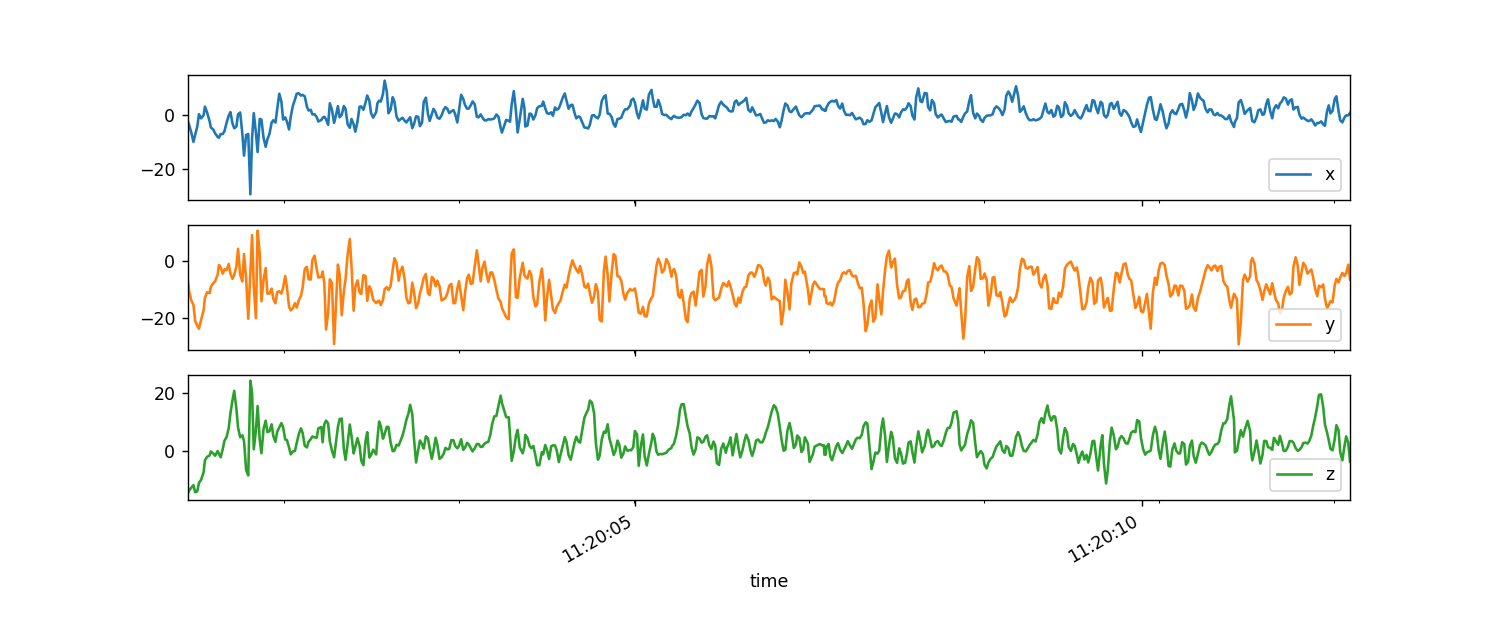

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B070CDE08>,
      dtype=object)

In [210]:
cross_over2.plot(x='time', subplots=True)

<IPython.core.display.Javascript object>


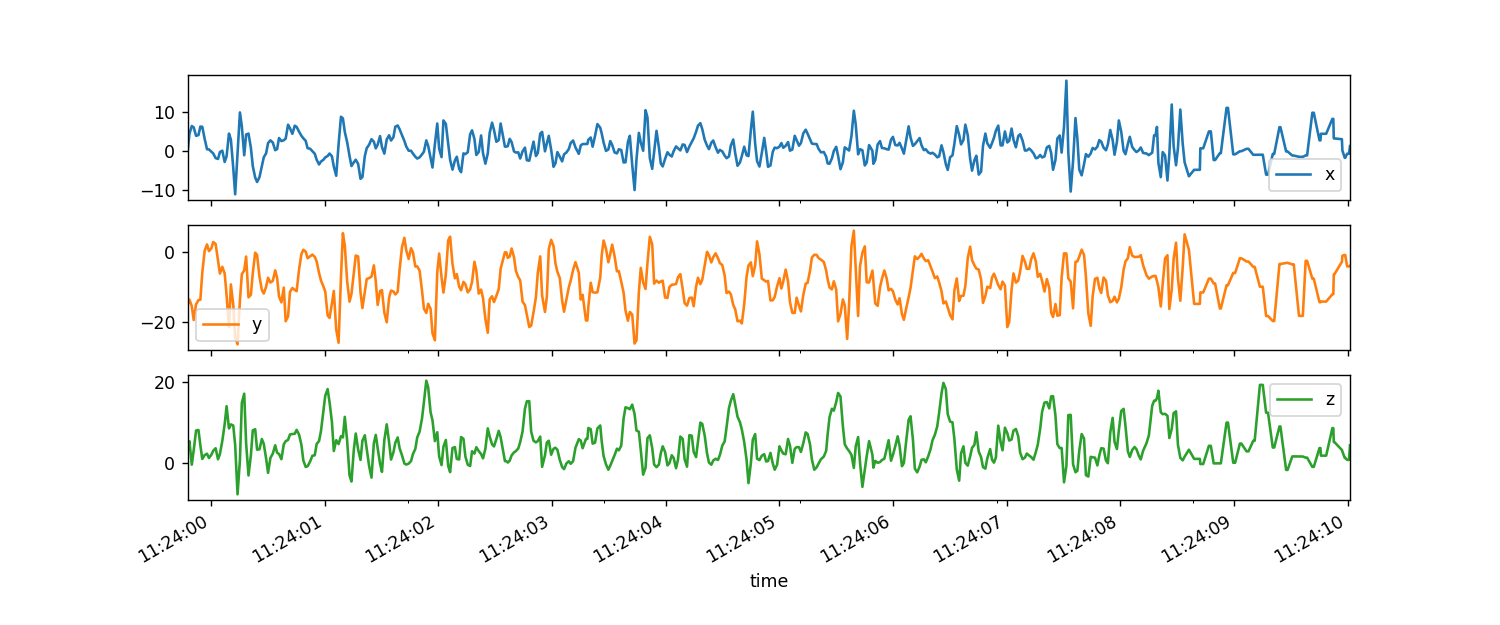

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B071C7BC8>,
      dtype=object)

In [211]:
cross_over5.plot(x='time', subplots=True)

In [212]:
#segmentation + feature extraction
cross_over2 =  feature_extraction_segmentation(cross_over2,10, True)
cross_over3 =  feature_extraction_segmentation(cross_over3,10, True)
cross_over4 =  feature_extraction_segmentation(cross_over4,10, True)
cross_over5 =  feature_extraction_segmentation(cross_over5,10, True)
cross_over5

x_mean    y_mean    z_mean      x_min      y_min     z_min      x_max  \
0  0.845499 -8.723797  4.524327 -11.215159 -26.455048 -7.724031  18.137596   

      y_max      z_max     x_std  ...     x_med     y_med    z_med  \
0  6.271588  20.214565  3.614585  ...  0.435493 -8.376076  3.57727   

     activity        sma          smv     tilt        x_psd         y_psd  \
0  cross_over  16.688276  6297.848101  1.46653  7428.184704  63021.664303   

          z_psd  
0  24568.330122  

[1 rows x 22 columns]

In [213]:
cross_over = pd.concat([cross_over2, cross_over3, cross_over4, cross_over5], ignore_index=True)
cross_over

x_mean    y_mean    z_mean      x_min      y_min      z_min      x_max  \
0  0.545804 -9.245215  2.880492 -29.448469 -29.230721 -14.897714  12.583855   
1  1.287523 -8.274007  4.664566 -16.840685 -24.327827  -5.335995  13.552947   
2  0.786552 -8.742420  4.519715  -9.992428 -25.217958  -8.415557  14.694324   
3  0.994259 -8.751638  4.408512  -6.400801 -27.806992  -4.785645  14.282759   
4  1.132581 -8.836385  4.227249  -9.760324 -28.682766  -7.214360  17.194824   
5  1.322173 -8.580547  4.547107  -9.760324 -28.682766  -7.214360  17.194824   
6  0.845499 -8.723797  4.524327 -11.215159 -26.455048  -7.724031  18.137596   

       y_max      z_max     x_std  ...     x_med     y_med     z_med  \
0  10.537991  24.081367  3.910211  ...  0.326620 -9.122636  2.245664   
1   5.359923  22.454248  3.436970  ...  1.048056 -8.444271  3.627519   
2   4.993821  19.298115  3.154448  ...  0.447458 -8.791230  3.381058   
3   4.993821  19.343578  3.009546  ...  0.409173 -8.958728  3.391826   
4   9.497113  19.343578  3.467941  ...  0.405583 -8.767303  3.354737   
5   9.497113  19.121046  3.833699  ...  0.647258 -8.635697  3.773481   
6   6.271588  20.214565  3.614585  ...  0.435493 -8.376076  3.577270   

     activity        sma          smv      tilt        x_psd         y_psd  \
0  cross_over  16.844566  6142.707138  1.506245  8059.113576  63410.770405   
1  cross_over  16.105610  5804.684322  1.470976  6979.365174  52989.541159   
2  cross_over  16.220926  5882.367139  1.486849  5475.466223  57965.927287   
3  cross_over  15.844029  5771.900304  1.454272  5194.729256  57066.596770   
4  cross_over  16.275264  5890.643096  1.445631  6882.219565  60222.646474   
5  cross_over  16.742354  5933.050928  1.457078  8504.016257  58113.594851   
6  cross_over  16.688276  6297.848101  1.466530  7428.184704  63021.664303   

          z_psd  
0  19059.953406  
1  23764.822671  
2  22632.128659  
3  20930.398606  
4  20447.672101  
5  22197.118112  
6  24568.330122  

[7 rows x 22 columns]

## forward 180

In [214]:
forward_180 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180_2.csv", sep=';', header=0, skipinitialspace=True)

forward_180 = preprocess(forward_180, "forward_180")

forward_180

time          x          y         z  \
202  1970-01-01 11:32:59.263336448 -18.680767 -12.942778  5.675776   
203  1970-01-01 11:32:59.284307968 -16.331015 -10.521241  5.505885   
204  1970-01-01 11:32:59.305279488 -17.601603  -3.617948  5.479564   
205  1970-01-01 11:32:59.322056704 -18.474983  -5.826523  7.613962   
206  1970-01-01 11:32:59.343028224 -16.907684  -7.776674  8.197810   
...                            ...        ...        ...       ...   
6468 1970-01-01 11:35:00.143177728 -12.038291 -13.261024  5.472385   
6469 1970-01-01 11:35:00.176732160 -10.920842 -16.847864  3.247060   
6470 1970-01-01 11:35:00.197703680 -10.681561 -11.755938  1.277767   
6471 1970-01-01 11:35:00.206092288 -10.681561 -11.755938  1.277767   
6472 1970-01-01 11:35:00.218675200  -8.951550  -7.247860  2.098505   

         activity  
202   forward_180  
203   forward_180  
204   forward_180  
205   forward_180  
206   forward_180  
...           ...  
6468  forward_180  
6469  forward_180  
6470  forward_180  
6471  forward_180  
6472  forward_180  

[6268 rows x 5 columns]

<IPython.core.display.Javascript object>


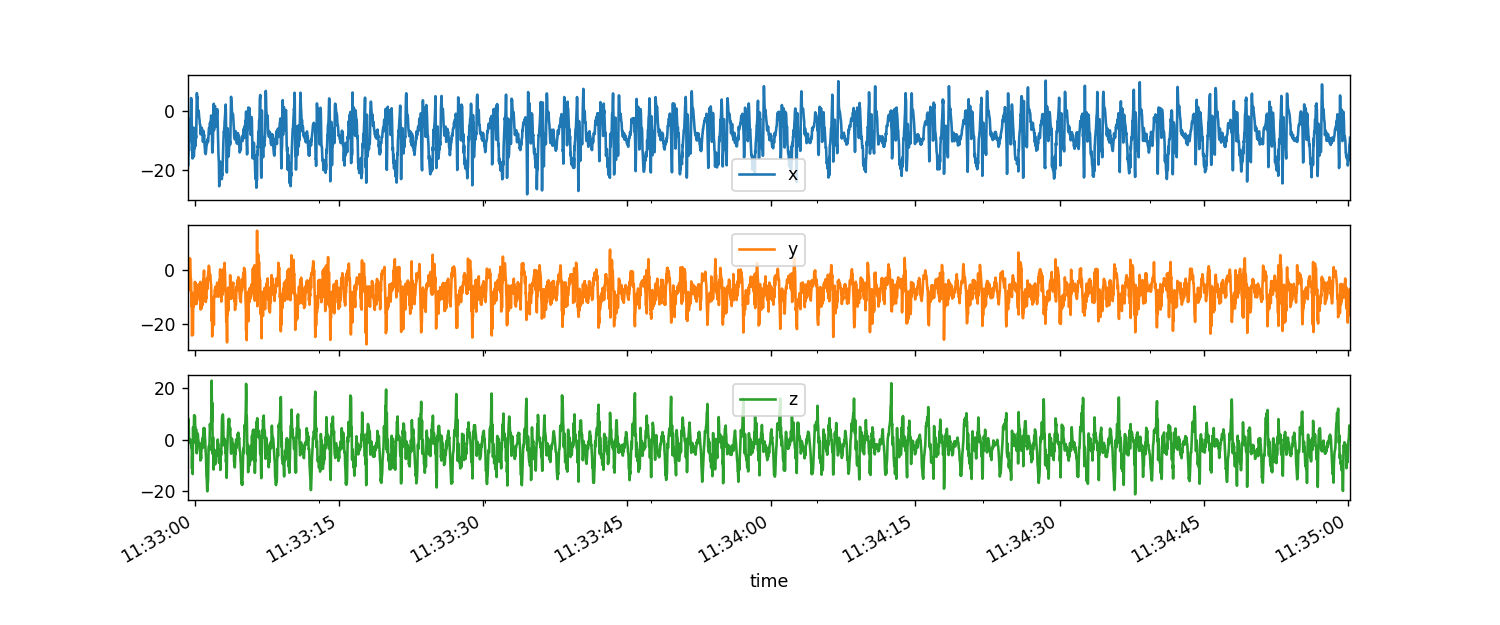

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B07302988>,
      dtype=object)

In [215]:
forward_180.plot(x='time', subplots=True)

In [216]:
#segmentation + feature extraction
forward_180 =  feature_extraction_segmentation(forward_180,10, True)
forward_180

x_mean    y_mean    z_mean      x_min      y_min      z_min      x_max  \
0  -8.288337 -7.987749 -1.976038 -25.875984 -26.902506 -20.056639   6.896115   
1  -8.851277 -7.614770 -2.467314 -25.875984 -26.072195 -19.578075   6.896115   
2  -8.744787 -7.763952 -2.367375 -25.342384 -27.617958 -19.578075   6.348158   
3  -8.093288 -7.948832 -2.459286 -24.196222 -27.617958 -17.666210   6.348158   
4  -8.354953 -7.587203 -2.489061 -25.048067 -25.115067 -18.570696   6.099305   
5  -8.302366 -7.396395 -2.582515 -25.048067 -25.115067 -18.570696   5.635098   
6  -7.648251 -7.625279 -2.459817 -28.103703 -24.351755 -17.809778   6.486942   
7  -7.766470 -7.831505 -1.965574 -28.103703 -21.456440 -16.742580   7.578069   
8  -7.731705 -7.828672 -2.292842 -26.981468 -21.456440 -16.742580   7.578069   
9  -7.352778 -7.895111 -2.099010 -22.451855 -20.915663 -16.354942   6.781260   
10 -7.418217 -8.120898 -1.827414 -22.451855 -23.239094 -16.936399   8.494520   
11 -7.371141 -8.056990 -1.881576 -23.842085 -23.239094 -16.936399   8.494520   
12 -6.586983 -8.011979 -1.743735 -23.842085 -24.894926 -15.462420  10.186246   
13 -7.144668 -7.805457 -1.644668 -22.425533 -24.894926 -15.462420  10.186246   
14 -7.571025 -7.609596 -1.841351 -21.877577 -25.916662 -19.037296   8.480164   
15 -7.091114 -7.544999 -2.309572 -21.856043 -25.916662 -19.037296   8.480164   
16 -6.896783 -7.695590 -2.337806 -22.494926 -20.975483 -16.795221  10.356136   
17 -7.495646 -7.948111 -2.221445 -22.794029 -20.975483 -17.137396  10.356136   
18 -7.849632 -7.858039 -2.483353 -22.794029 -23.155344 -21.229122   9.844072   
19 -7.376259 -7.858824 -2.451299 -22.935205 -23.155344 -21.229122   9.844072   
20 -7.709430 -7.712847 -2.558135 -22.935205 -23.679373 -17.886349   8.252846   
21 -7.471337 -7.841257 -3.065492 -24.416363 -23.679373 -18.305094   7.884351   
22 -7.209843 -7.835684 -2.882375 -24.416363 -23.380270 -18.386450   9.111869   

        y_max      z_max     x_std  ...     x_med     y_med     z_med  \
0   14.392828  22.884956  6.209234  ... -8.221739 -7.994421 -2.036292   
1   14.392828  21.647867  6.296196  ... -8.684750 -7.519445 -2.316253   
2    5.309673  18.597017  6.419323  ... -8.368897 -7.607979 -2.372484   
3    3.852444  19.444077  6.078856  ... -8.019545 -7.774281 -2.687140   
4    5.479564  19.444077  6.385563  ... -8.013563 -7.367501 -2.411965   
5    5.479564  17.898314  6.389940  ... -7.884351 -7.386643 -2.383251   
6    4.804788  17.898314  6.284801  ... -7.389036 -7.441679 -2.557927   
7    7.405786  17.168503  6.508710  ... -7.643872 -7.655836 -2.141577   
8    7.405786  18.025133  6.027040  ... -7.948957 -7.905886 -2.306681   
9    3.917051  18.025133  5.777632  ... -7.523035 -7.972885 -2.251646   
10   3.917051  16.646868  6.137981  ... -7.361518 -8.069794 -1.834099   
11   4.175476  15.967305  5.796891  ... -7.715656 -7.916654 -1.834099   
12   4.175476  15.967305  5.511863  ... -6.507281 -7.600801 -1.788635   
13   4.316652  21.913469  6.035773  ... -6.831509 -7.313662 -1.505086   
14   4.316652  21.913469  6.041668  ... -8.316256 -7.310073 -1.701297   
15   2.029114  12.634104  5.583441  ... -8.006385 -7.322037 -1.861616   
16   6.319445  15.687346  5.941469  ... -7.302895 -7.357930 -1.892723   
17   6.319445  16.204195  6.565093  ... -7.316056 -7.612766 -2.094917   
18   3.821338  16.374084  6.294496  ... -7.974082 -7.462017 -2.299503   
19   3.632305  16.374084  5.784161  ... -7.860422 -7.234699 -1.954936   
20   4.206582  15.608382  5.957319  ... -7.862815 -7.362715 -1.974079   
21   5.383851  15.608382  6.325091  ... -7.633104 -7.637890 -2.586641   
22   5.383851  12.028720  6.038557  ... -7.695318 -7.463214 -2.787638   

       activity        sma          smv      tilt         x_psd         y_psd  \
0   forward_180  22.441915  7566.767155  2.202439  55624.769673  47843.055343   
1   forward_180  22.680180  7668.405980  2.234835  61077.725735  45820.096256   
2   forward_180  22.095911  7505.861204  2.232287  60916.520715  45517.034984   
3   forw

## shuffle - balance data

In [227]:
shape = np.min([jump_fast.shape[0], jump_slow.shape[0], side_swing.shape[0], cross_over.shape[0], forward_180.shape[0]])
print(jump_fast.shape, jump_slow.shape, side_swing.shape, cross_over.shape, forward_180.shape)
jump_fast = shuffle(jump_fast).head(shape).copy()
jump_slow = shuffle(jump_slow).head(shape).copy()
side_swing = shuffle(side_swing).head(shape).copy()
cross_over = shuffle(cross_over).head(shape).copy()
forward_180 = shuffle(forward_180).head(shape).copy()
jump_fast.shape

(16, 22) (14, 22) (18, 22) (7, 22) (23, 22)


(7, 22)

## merge all activities

In [228]:
#merge different activity dataframes
merged = pd.concat([jump_fast, jump_slow, side_swing, cross_over, forward_180], ignore_index=True) 
target = merged['activity']
merged

x_mean     y_mean    z_mean      x_min      y_min      z_min      x_max  \
0  -5.095262 -10.126370 -1.405372 -36.258442 -34.913673 -23.150558  11.722438   
1  -5.429781  -9.660199 -1.580376 -32.384460 -29.178080 -20.181067  10.535598   
2   5.874449  -8.469493 -4.737341 -15.641882 -29.967710 -19.070797  47.212784   
3  -8.196665  -8.206268 -2.434212 -39.397823 -33.413376 -27.349962   9.669396   
4  -8.169064  -7.995196 -2.028957 -39.397823 -33.413376 -28.922047   9.669396   
5  -7.583159  -8.936538 -3.239117 -34.935211 -34.614571 -27.349962   8.568698   
6  -4.744691  -9.403931 -2.639542 -32.013573 -36.191441 -27.768707  16.943577   
7  -5.084023  -8.429078 -5.237145 -24.428326 -25.562525 -19.283758   9.126225   
8  -1.775280  -9.387140 -3.656141 -16.036697 -27.620352 -15.314065   9.276974   
9  -5.481726  -8.859617 -4.460138 -25.507490 -23.327627 -20.379671   6.252446   
10  4.420618  -9.092482 -2.320927 -31.324442 -29.032118 -24.961926  44.618965   
11 -1.824405  -9.533217 -3.602798 -16.036697 -27.680172 -21.025732   9.276974   
12 -5.246818  -8.616536 -4.756654 -23.976084 -23.990440 -20.152351   5.816952   
13  4.476976  -9.210593 -1.860263 -35.535809 -27.641888 -15.627524  58.150375   
14 -0.151709  -6.735745 -2.689505  -7.707282 -20.054247 -19.812571   5.441278   
15  1.674619  -7.236423 -0.801309  -8.800801 -18.742979 -21.956541  14.151154   
16  0.408326  -6.751972 -2.342814  -5.000999 -20.054247 -19.812571   7.118648   
17  1.541361  -7.126066 -0.300706  -8.800801 -18.742979 -19.688145  15.912271   
18  3.430833  -6.141560 -1.081459  -8.078169 -18.415163 -21.135803  20.946770   
19  1.663866  -6.564681 -2.762301  -7.475178 -16.989040 -18.132811  13.907085   
20  1.579152  -7.433271 -2.380267  -7.475178 -17.898314 -19.597218  13.615161   
21  0.545804  -9.245215  2.880492 -29.448469 -29.230721 -14.897714  12.583855   
22  1.287523  -8.274007  4.664566 -16.840685 -24.327827  -5.335995  13.552947   
23  1.322173  -8.580547  4.547107  -9.760324 -28.682766  -7.214360  17.194824   
24  1.132581  -8.836385  4.227249  -9.760324 -28.682766  -7.214360  17.194824   
25  0.994259  -8.751638  4.408512  -6.400801 -27.806992  -4.785645  14.282759   
26  0.845499  -8.723797  4.524327 -11.215159 -26.455048  -7.724031  18.137596   
27  0.786552  -8.742420  4.519715  -9.992428 -25.217958  -8.415557  14.694324   
28 -7.471337  -7.841257 -3.065492 -24.416363 -23.679373 -18.305094   7.884351   
29 -7.418217  -8.120898 -1.827414 -22.451855 -23.239094 -16.936399   8.494520   
30 -7.495646  -7.948111 -2.221445 -22.794029 -20.975483 -17.137396  10.356136   
31 -7.091114  -7.544999 -2.309572 -21.856043 -25.916662 -19.037296   8.480164   
32 -6.586983  -8.011979 -1.743735 -23.842085 -24.894926 -15.462420  10.186246   
33 -7.352778  -7.895111 -2.099010 -22.451855 -20.915663 -16.354942   6.781260   
34 -7.709430  -7.712847 -2.558135 -22.935205 -23.679373 -17.886349   8.252846   

        y_max      z_max      x_std  ...     x_med     y_med     z_med  \
0   13.576876  18.857836   9.907339  ... -1.490728 -9.939785 -2.294717   
1   13.962120  21.824936   9.539299  ... -2.384447 -9.460024 -2.727818   
2    9.743574  10.808380   8.778388  ...  4.622933 -8.130812 -5.324031   
3   19.688145  21.080767   8.056542  ... -6.782456 -9.156136 -1.135394   
4   19.688145  21.080767   8.146689  ... -6.300302 -8.797212 -1.366302   
5   13.466805  20.130817   8.144810  ... -6.446264 -9.116654 -2.969493   
6   10.650454  19.118652   9.427057  ... -1.660619 -8.700303 -3.503092   
7    4.733003   9.657433   6.499475  ... -3.670590 -7.877172 -5.827720   
8    3.086741   6.668797   4.655250  ... -1.610370 -8.749356 -3.979264   
9    3.897908  12.571890   6.594594  ... -4.156333 -9.358330 -3.842873   
10   5.850451  12.043077   9.788514  ...  2.364109 -9.272188 -1.682154   
11   3.086741   6.668797   4.710011  ... -1.703690 -8.793623 -3.993621   
12   3.471986   9.698111   6.474394  ... -3.507878 -8.634500 -4.521238   
13   8.640483  12.602997  10.762388  ...  2.176272 -9

## dimensionality reduction

In [234]:
pca = PCA(n_components=10)
merged = pd.DataFrame(pca.fit_transform(merged.drop('activity', axis=1)))
merged['activity'] = target
merged

0             1             2           3          4  \
0   36357.630632 -10370.007989  -9873.729853 -127.899799   2.554182   
1   33867.122284  -5080.419674  -6851.138028 -134.428861  -0.035972   
2   23572.916879 -17829.876430    773.136549  104.511182 -17.351438   
3   47373.364698  29533.456808 -10125.540168  -77.344608  -6.040255   
4   45977.343927  25853.720906  -6839.191281  -95.769541  -5.426838   
5   45059.326705  27784.526761 -16111.042395  -43.032719  -1.757405   
6   33084.251367  -5352.525905 -17088.146584  -51.328035   1.591919   
7    4168.218030   2047.770448  -4232.073414   74.607839  12.274541   
8  -17985.300236 -14349.344332 -16143.549899  -70.405860  11.840196   
9    7847.043322   -824.920575  -6517.131888  132.256079  16.582377   
10  24239.761703 -24103.294579   2155.074198  468.620723   0.755576   
11 -16929.239937 -14851.997776 -17845.455319  -69.788368  13.660231   
12   5465.852145    686.963814  -6005.881463  192.752923  18.942685   
13  30672.482945 -28531.756934  12530.774663  638.332488  -6.678578   
14 -30390.782543  18755.128338    605.872761   91.907491   5.536839   
15 -21709.318930  16723.836451   6077.150779  145.093954  -1.182701   
16 -31023.390164  18467.135910   2146.416277   62.562966   2.620586   
17 -20403.035202  14500.969596   8662.009429  191.331269  -1.429009   
18  -8923.826544  25047.460695  12404.955140  351.399254  -4.992179   
19 -23379.003031  21142.104627   8057.604924  114.899829  -1.698677   
20 -25555.464826   8674.295453   7559.074120   78.129955   2.345438   
21 -24444.896802 -11891.704969 -12312.316122 -201.603125  -5.109839   
22 -26380.413508  -1994.112378  -6811.264492   17.117462  -6.132201   
23 -24277.644790  -6401.938338  -9495.280851    4.855992  -8.413288   
24 -25832.611535  -8784.306388 -10925.904414  -15.120640  -7.902681   
25 -27971.759831  -6351.899233  -9325.026795   -8.436215  -6.453765   
26 -23280.459613  -7122.012548 -14921.877679 -198.422865 -13.063749   
27 -26931.511842  -5527.728844 -10751.148652  -30.794260  -5.684066   
28   9031.670098  -6772.874940  18606.807890 -202.038706   3.460528   
29   7056.867579  -8828.668191  18062.853223 -211.791487   2.376365   
30  10698.265684  -5535.162096  19525.409731 -206.747715   0.041107   
31     22.254849  -4127.221913  21592.786157 -195.169835   3.336798   
32  -1885.490935  -5810.940137  14902.557787 -247.223058  -0.856731   
33   4303.798668  -4897.357477  18770.237017 -235.246421   1.561213   
34   8505.978755  -3877.298162  19742.978654 -245.787288   0.728792   

            5          6         7         8         9     activity  
0   -1.207786  -0.397286  3.937188 -2.353104  1.216931    jump_fast  
1   -1.871662  -4.260487  4.556723  0.394484  4.238331    jump_fast  
2   20.373421  -0.535540 -1.536989  0.617075  2.282644    jump_fast  
3   -3.339907   1.748716 -3.815463 -0.051808  0.300112    jump_fast  
4   -3.290534   3.366198 -2.508956 -1.867956  0.679365    jump_fast  
5    0.911986  -1.589105 -1.045596  2.127030 -3.409032    jump_fast  
6    4.384284   1.918891  5.280835 -1.347901 -2.685913    jump_fast  
7    0.210228  -0.563154 -3.844270  1.774192  0.464843    jump_slow  
8    6.696167   0.796451 -3.218858  0.962263 -0.117401    jump_slow  
9   -3.703143  -3.787399  0.914187  1.990333  0.797651    jump_slow  
10  -0.321859   4.922885  2.466199 -1.312811 -1.561263    jump_slow  
11   8.811256   3.693769 -0.337541 -0.738954 -0.674972    jump_slow  
12  -3.319626  -4.438463 -0.927922  0.526228  0.575786    jump_slow  
13  -7.351837   1.607723 -4.330086  1.231214 -0.066468    jump_slow  
14   1.817440   2.545595 -2.166297 -2.677404  2.075988   side_swing  
15   1.318769   2.437088  5.266153  0.636118 -1.063790   side_swing  
16   4.337665   2.095921 -1.764463 -3.248569  1.831813   side_swing  
17  -0.563420   0.260696  4.404572  0.295795 -1.136185   side_swing  
18   0.386146  -2.546801  2.850181 -1.195319  0.548567   side_swing  
19   4.854683   1.351922 -0.600156  3.509848  0.455713   s

## train-test split

In [235]:
#TODO: NIET NODIG!!!
#standardize
#scaler = preprocessing.StandardScaler().fit(df)
#df = pd.DataFrame(scaler.transform(df), columns=column_names[2:])

#label activity
le = preprocessing.LabelEncoder()
le.fit(merged['activity'])
merged['activity'] = le.transform(merged['activity'])
labels = le.inverse_transform([0,1,2,3,4])

#train test split
X_train, X_test, y_train, y_test = train_test_split(merged.drop('activity', axis=1), merged['activity'], test_size = 0.33, random_state = 42)

#normalize X
xNormalizer = preprocessing.Normalizer().fit(X_train)
X_train = xNormalizer.transform(X_train)
X_test = xNormalizer.transform(X_test)

# transitions

In [ ]:
def extract_windows(start, length):
    

### jump slow - jump fast

In [218]:
js_jf = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow-jump_fast.csv", sep=';', header=0, skipinitialspace=True)

js_jf = preprocess(js_jf, "js_jf")

js_jf

time          x          y          z activity
205  1970-01-01 11:46:23.479185408  -7.427321 -13.986049  -9.903893    js_jf
206  1970-01-01 11:46:23.495962624 -13.399807 -15.713666 -11.956935    js_jf
207  1970-01-01 11:46:23.516934144 -12.684353 -19.204794 -13.469198    js_jf
208  1970-01-01 11:46:23.533711360  -7.793423 -17.364714 -10.679168    js_jf
209  1970-01-01 11:46:23.558877184  -4.070191 -14.840286  -8.817552    js_jf
...                            ...        ...        ...        ...      ...
2916 1970-01-01 11:47:15.756990464  -2.818745   3.644269 -14.902499    js_jf
2917 1970-01-01 11:47:15.773767680  -4.357330  -2.115255 -15.680167    js_jf
2918 1970-01-01 11:47:15.794739200  -7.716853   1.622334 -17.271395    js_jf
2919 1970-01-01 11:47:15.815710720  -7.724031   2.289931  -9.492328    js_jf
2920 1970-01-01 11:47:15.832487936 -12.253645  -3.498307  -4.268795    js_jf

[2714 rows x 5 columns]

<IPython.core.display.Javascript object>


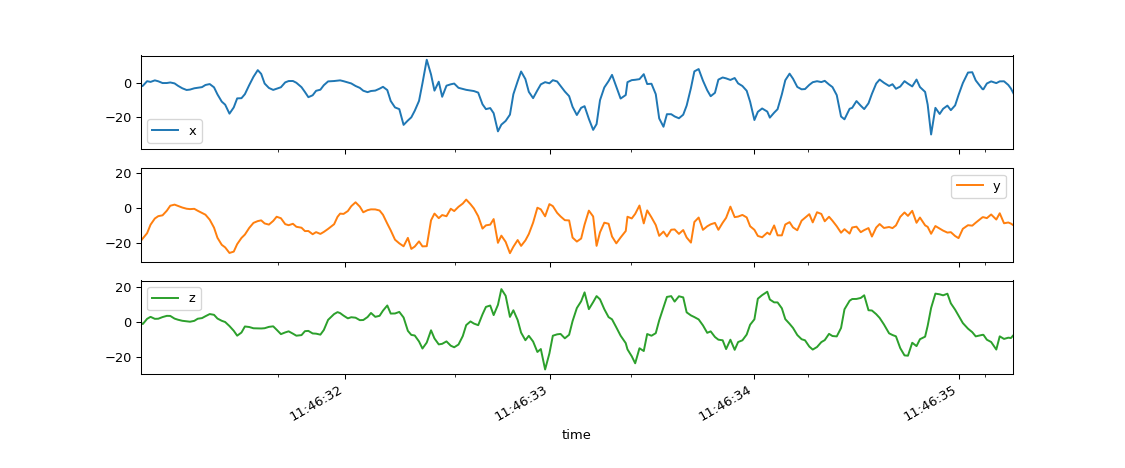

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B0ED49088>,
      dtype=object)

In [219]:
js_jf.plot(x='time', subplots=True)

### jump slow - cross over

In [220]:
js_co = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow-cross_over.csv", sep=';', header=0, skipinitialspace=True)

js_co = preprocess(js_co, "js_co")

js_co

time         x         y          z activity
201  1970-01-01 11:48:41.123659776 -3.699304 -8.360522  -2.562713    js_co
202  1970-01-01 11:48:41.140436992 -4.515256 -9.681360  -3.962514    js_co
203  1970-01-01 11:48:41.161408512 -4.508078 -9.882358  -4.187439    js_co
204  1970-01-01 11:48:41.182380032 -2.354537 -9.822537  -3.330809    js_co
205  1970-01-01 11:48:41.199157248 -1.229911 -9.595219  -3.940979    js_co
...                            ...       ...       ...        ...      ...
1822 1970-01-01 11:49:12.396390400 -2.672783 -4.027121   3.335595    js_co
1823 1970-01-01 11:49:12.421556224 -2.543571 -3.893122   5.056034    js_co
1824 1970-01-01 11:49:12.438333440 -2.210968 -7.800602   5.802595    js_co
1825 1970-01-01 11:49:12.455110656 -2.359323 -8.317451   9.930214    js_co
1826 1970-01-01 11:49:12.476082176 -1.241875 -9.999606  16.790436    js_co

[1624 rows x 5 columns]

<IPython.core.display.Javascript object>


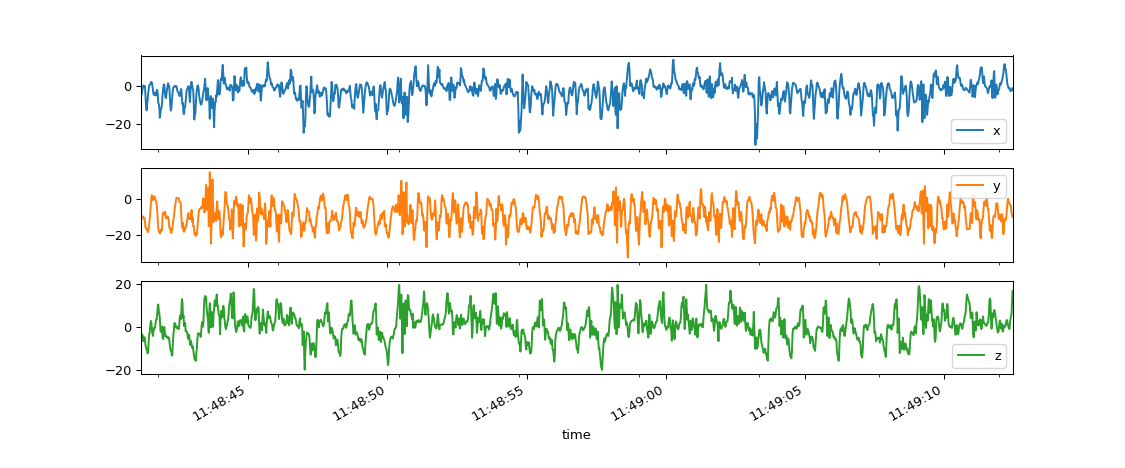

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B72276B88>,
      dtype=object)

In [221]:
js_co.plot(x='time', subplots=True)

### jump slow - side swing

In [222]:
js_ss = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow-side_swing.csv", sep=';', header=0, skipinitialspace=True)

js_ss = preprocess(js_ss, "js_ss")

js_ss

time         x          y         z activity
200  1970-01-01 11:50:07.559876608 -0.859023  -9.714860 -6.697511    js_ss
201  1970-01-01 11:50:07.580848128  5.051249 -10.504492 -5.905486    js_ss
202  1970-01-01 11:50:07.597625344  6.601798 -10.006784 -4.599005    js_ss
203  1970-01-01 11:50:07.618596864 -1.210768  -7.898707 -3.828516    js_ss
204  1970-01-01 11:50:07.635374080  0.260818 -12.325429 -4.424329    js_ss
...                            ...       ...        ...       ...      ...
3699 1970-01-01 11:51:15.075588096 -4.539185  -6.525228 -6.879365    js_ss
3700 1970-01-01 11:51:15.100753920 -2.249253  -7.075577 -5.998806    js_ss
3701 1970-01-01 11:51:15.125919744 -1.268196  -7.640283 -5.874380    js_ss
3702 1970-01-01 11:51:15.134308352 -0.047856  -7.379465 -7.015756    js_ss
3703 1970-01-01 11:51:15.155279872  0.179462  -9.518648 -6.245267    js_ss

[3503 rows x 5 columns]

<IPython.core.display.Javascript object>


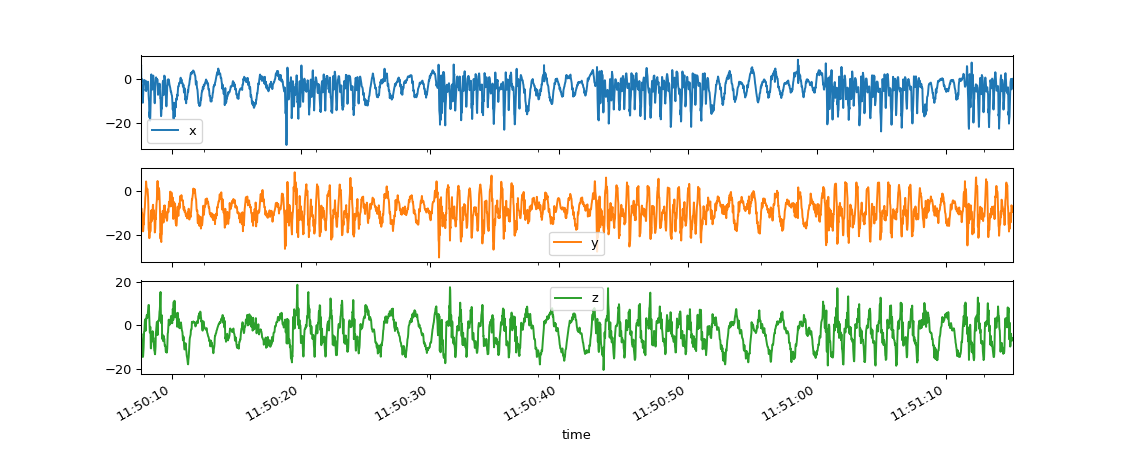

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B107F92C8>,
      dtype=object)

In [223]:
js_ss.plot(x='time', subplots=True)

### jump slow - forward 180

In [224]:
js_f180 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow-forward_180.csv", sep=';', header=0, skipinitialspace=True)

js_f180 = preprocess(js_f180, "js_f180")

js_f180

time          x          y          z activity
203  1970-01-01 11:51:58.625046528 -11.578869 -13.540983 -17.570498  js_f180
204  1970-01-01 11:51:58.646018048  -9.186047 -12.983456 -17.218752  js_f180
205  1970-01-01 11:51:58.662795264  -5.922236 -12.763316 -14.723038  js_f180
206  1970-01-01 11:51:58.683766784  -2.940779 -12.827922  -9.133404  js_f180
207  1970-01-01 11:51:58.704738304   0.011964 -12.004791  -5.331209  js_f180
...                            ...        ...        ...        ...      ...
3395 1970-01-01 11:53:00.218400768   1.820938 -10.358529  -4.271188  js_f180
3396 1970-01-01 11:53:00.239372288   3.297310 -10.281959  -3.194418  js_f180
3397 1970-01-01 11:53:00.256149504   3.646662  -6.501299  -1.940579  js_f180
3398 1970-01-01 11:53:00.277121024   3.864408  -1.500300  -1.028914  js_f180
3399 1970-01-01 11:53:00.293898240   2.478964   1.447658  -0.815953  js_f180

[3196 rows x 5 columns]

<IPython.core.display.Javascript object>


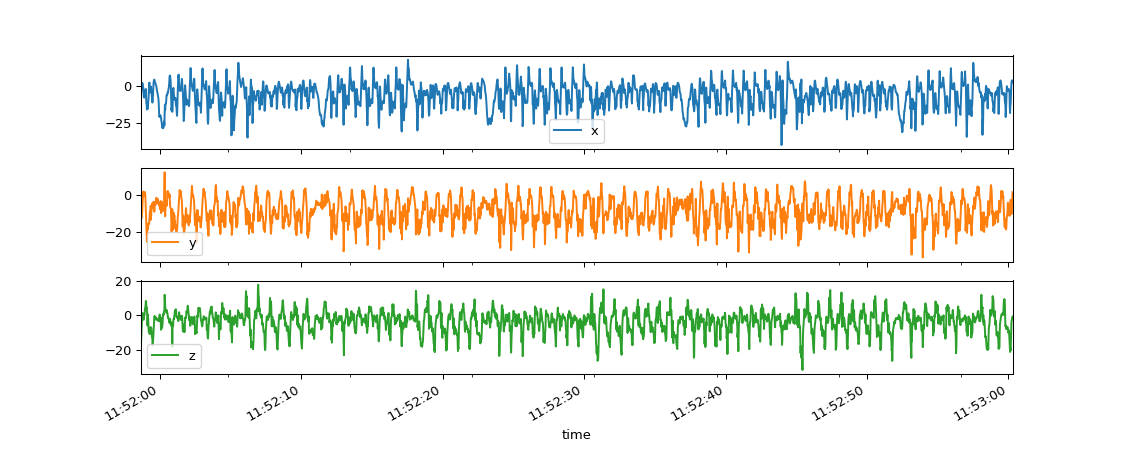

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B10DAB508>,
      dtype=object)

In [225]:
js_f180.plot(x='time', subplots=True)

# machine learning algorithms

## SVC

<IPython.core.display.Javascript object>


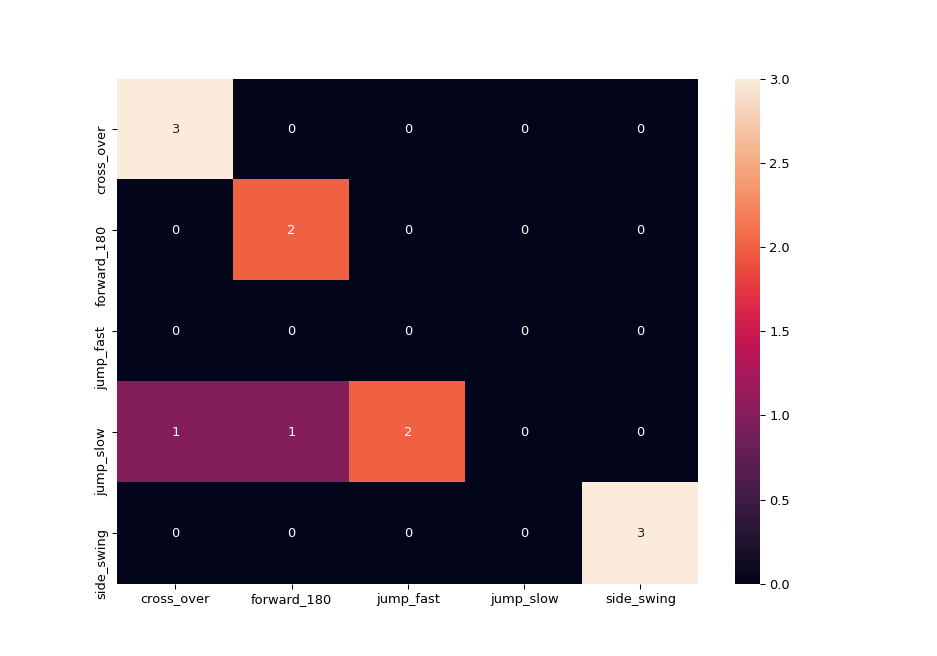

In [236]:
#hyperparameter tuning
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear','rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True) #verbose=2
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)

<IPython.core.display.Javascript object>


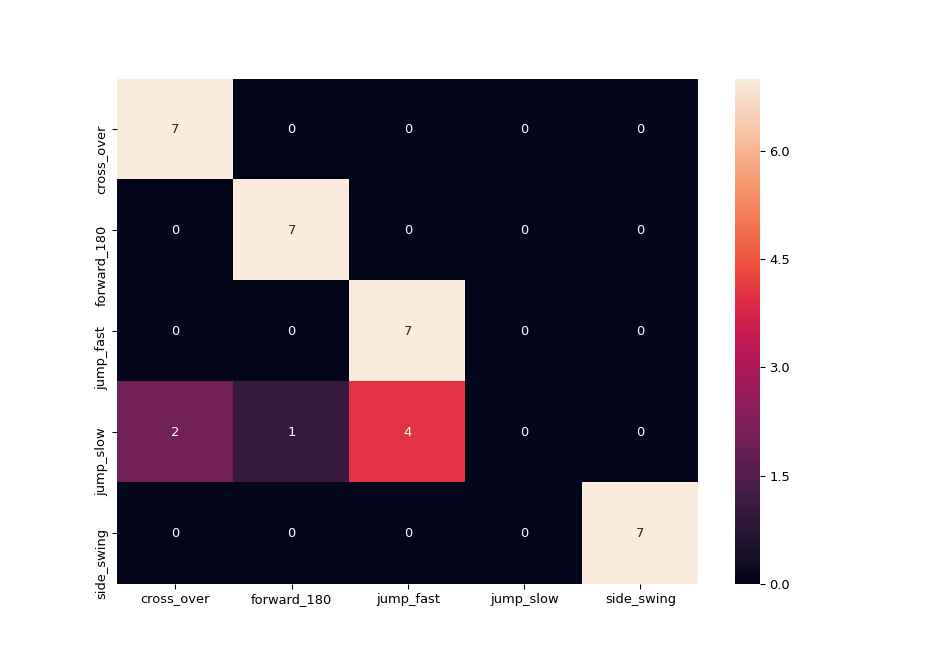

In [237]:
y_pred = clf.predict(merged.drop('activity', axis=1).to_numpy())
cm = confusion_matrix( merged['activity'].to_numpy(), y_pred)

heatmap(cm, labels)

## linear SVC

In [ ]:
#hyperparameter tuning
param_grid = {'C': [0.1,1, 10, 100]}
grid = GridSearchCV(LinearSVC(),param_grid,refit=True)
grid.fit(X_train,y_train)

clf =  grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm,labels)

## random forest

In [ ]:
#hyperparameter tuning
param_grid = {'n_estimators': [100, 1000],
              'max_depth': [10, 20],'min_samples_split': np.arange(0.10, 1, 0.4) ,
              'max_leaf_nodes': [10, 100, 1000, None]}
grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)

## extra trees classifier

In [ ]:
#hyperparameter tuning
param_grid = {'n_estimators': [10, 100, 1000],
              'max_depth': [1,10,20,30],'min_samples_split': np.arange(0.10, 1, 0.2) ,
                'max_leaf_nodes': [10, 100, 1000, None]}
grid = GridSearchCV(ExtraTreesClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm)

## AdaBoost

In [ ]:
#hyperparameter tuning
param_grid = {'learning_rate': np.arange(0.10, 1, 0.2), 'n_estimators': [10, 50, 100, 1000],
              'base_estimator': [RandomForestClassifier(), ExtraTreesClassifier()], 
              'algorithm' : ['SAMME', 'SAMME.R']}
grid = GridSearchCV(AdaBoostClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm)

## naive bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm)

## kneighbors 

In [ ]:
#hyperparameter tuning
param_grid = {'n_neighbors': [1,2,4,8,10], 'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'leaf_size': range(1,60,10), 
              'metric' : ['minkowski']}
grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm)

## SGD classifier

In [ ]:
#hyperparameter tuning
param_grid = {'alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'], 
              'max_iter': [10, 100, 1000], #np.ceil(10**6 / n) 
             'shuffle' : [True], 'eta0' : [1]}
grid = GridSearchCV(SGDClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm)

## MLP classifier

Fitting 3 folds for each of 864 candidates, totalling 2592 fits
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=0.0001, hidden_l

[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=0.0001, hidden_layer_siz

[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=  

[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=identity, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=0.001, hidden_la

[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd 
[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd 
[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV

[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_

[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd 
[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.1s
[CV] activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd 
[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=  

[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=co

[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learnin

[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50),

[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.5s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.5s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), lear

[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_r

[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes

[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[

[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=identity, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=identity, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=identity, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=100.0, hidden_l

[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, 

[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, alpha=1000.0, hidden_layer_s

[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=identity, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(100

[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs, total=   0.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs, total=   0.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=logistic, alpha=0.0001, hidden_layer

[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs, total=   0.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs, total=   0.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden

[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 

[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.1s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.4s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=logistic, alpha=0.001, hidden_layer_

[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.1s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.

[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   2.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.1s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=logistic, alpha=0.01, hidden_laye

[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.1s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activ

[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adap

[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.2s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.1s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.1s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV

[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=co

[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learnin

[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.4s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50,

[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 

[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 50, 50), l

[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=100.0, hidden_

[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=  

[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=1000.0, hidden_

[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=constant, sol

[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=ada

[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, 

[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sg

[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, sol

[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, so

[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs, total=   0.2s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solv

[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.3s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.3s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.3s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solve

[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.4s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.4s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=

[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(50

[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.5s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, sol

[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes

[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.5s
[CV] activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.4s
[CV] activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.4s
[CV] activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invsca

[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=tanh, alpha=10.0, hidden_layer_s

[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, s

[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=tanh

[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=ada

[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.5s
[CV] activation=tanh, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=tanh, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=tanh, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=tanh, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd 
[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.0

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, 

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adap

[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=con

[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs, total=   0.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adapt

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscali

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sg

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_s

[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, so

[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_si

[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, 

[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(100,

[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=

[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=relu, alpha=

[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, so

[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.5s
[CV] activation=relu, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=relu, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=relu, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=relu, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd 
[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.2s
[CV] ac

[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.0s
[CV] activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.0s
[CV] activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.0s
[CV] activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, sol

[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.1s
[CV] activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.1s
[CV] activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adap

[Parallel(n_jobs=1)]: Done 2592 out of 2592 | elapsed:  9.2min finished


<IPython.core.display.Javascript object>


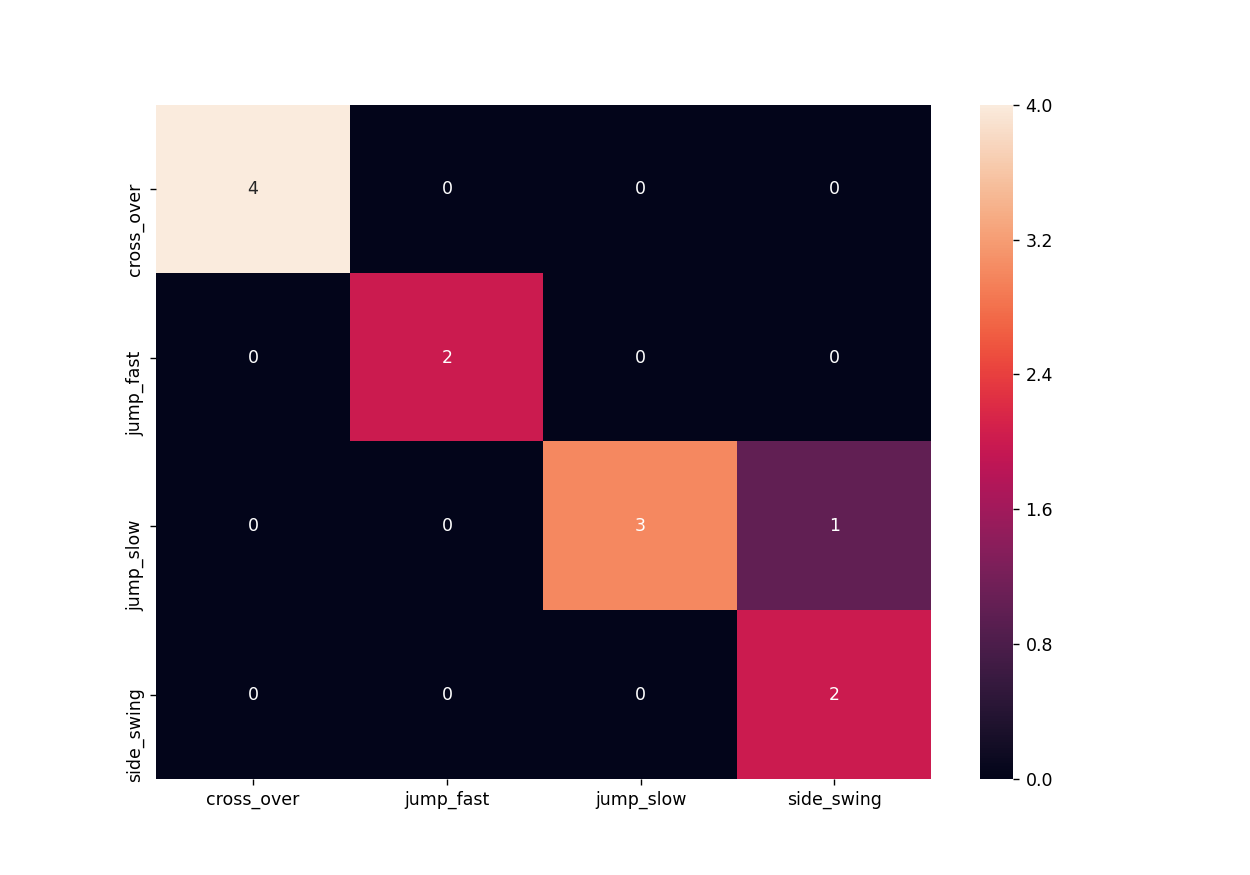

In [35]:
#hyperparameter tuning
param_grid = {'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], 
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)], 'activation': ['identity', 'logistic','tanh', 'relu'],
    'learning_rate': ['invscaling', 'constant','adaptive']}
grid = GridSearchCV(MLPClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)